# Address Scoring Model - Model Training - August 2022

In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import os
from glob import glob
import pickle as pk
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


today = datetime.strptime('2022-08-16', '%Y-%m-%d')
today

datetime.datetime(2022, 8, 16, 0, 0)

In [30]:
DATA_DATE = '2022-12-06'  # the date the data (AIMS, ODS, EDW, Humach, etc) was exported. 

# Corresponds to datalabs/analysis/address/scoring/data/{DATA_DATE}
assert os.path.exists(f'../../../../../datalabs/analysis/address/scoring/data/{DATA_DATE}')


In [11]:
TRAINING_FOLDER = '202208'  # /datalabs/analysis/address/scoring/training/{TRAINING_FOLDER}/

if not os.path.exists(TRAINING_FOLDER):
    os.mkdir(TRAINING_FOLDER)
    os.mkdir(f'{TRAINING_FOLDER}/features')

# Stage 1 - Prepare Humach sample+result data


To start, we need the following columns:

* me  - AMA's general physician ID
* entity_id  - physician ID from AIMS
* comm_id  - address ID from AIMS
* address_key  - combination of street address + 5 digit zip code
* state_cd  - not present in this snippet but I patched it in the data later. Required for license features.
* survey_date  - typically the sample generation date
* comments  - result field from Humach survey result file
* office_address_verified_updated  - flag value from Humach result file
* status  - 'CORRECT' or 'INCORRECT'  - determined by combination of 'comments' value and 'office_address_verified_updated'


Humach result data can be extracted from Derek's WSLIVE_RESULTS.sas7bdat file, located here:

- U:/Source Files/Data Analytics/Derek/SAS_DATA/SURVEY/wslive_results.sas7bdat

#### How to determine 'status':

If 'comments' value is in ['COMPLETE', 'RESPONDED TO SURVEY - AMA'] and 'office_address_verified_updated' value == 1, the phone call in the Humach surveying attempt was completed and did NOT result in the address being updated. If office_address_verified_updated == 2, it indicates the address that Humach gave back to us was updated/different than the address value we provided in the original survey sample.

The 'address_key' value in this data should be the SAMPLED address, not the RESULT address from Humach.

'status' is what we're trying to predict. INCORRECT = 0, CORRECT = 1



In [2]:
training_data = pd.read_csv('../data/2022-08-16/address_scoring_training_2022-08-16.txt', sep='|', dtype=str)

training_data

,me,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_id
0,00576081367,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,45742238
1,00512830081,7774210,4300 GOLDEN CENTER DR STE A_95667,2021-12-01,COMPLETE,1,CORRECT,1795894
2,70401940012,15135387,400 WESTAGE BUSINESS CTR DR STE 210_12524,2021-12-01,COMPLETE,1,CORRECT,13736433
3,02105961769,25976969,4429 CLARA ST STE 540_70115,2021-12-01,COMPLETE,1,CORRECT,4652332
4,56111960017,18826604,2330 MORSE RD STE A_43229,2021-12-01,COMPLETE,1,CORRECT,21579099
...,...,...,...,...,...,...,...,...
39886,03006920933,20976264,13015 W LINEBAUGH AVE_33626,2022-06-01,COMPLETE,1,CORRECT,6643802
39887,03840081094,811034,9500 EUCLID AVE_44195,2022-06-01,COMPLETE,2,INCORRECT,28375733
39888,03845830095,22418302,3535 SOUTHERN BLVD DEPT OF_45429,2022-06-01,COMPLETE,2,INCORRECT,8704120
39889,30803781342,7599181,66 CALLE SANTA CRUZ STE 310_00961,2022-06-01,COMPLETE,1,CORRECT,12302117


In [3]:
training_data['comments'].value_counts()

COMPLETE                     39811
MOVED, NO FORWARDING INFO       62
RESPONDED TO SURVEY - AMA       17
NOT IN SERVICE                   1
Name: comments, dtype: int64

In [4]:
training_data['survey_date'].value_counts()

2021-12-01    8779
2022-02-01    7565
2022-05-01    7361
2022-04-01    7034
2022-03-01    5195
2022-06-01    2114
2022-01-01    1843
Name: survey_date, dtype: int64

In [6]:

#if 'state_cd' not in training_data.columns.values:
#    addr = pd.read_csv('../data/2022-08-16/POST_ADDR_AT_PROCESSED.txt', sep='|', dtype=str)
#    training_data = training_data.drop_duplicates().merge(addr[['comm_id', 'state_cd']].drop_duplicates(), on='comm_id')
#training_data



# Stage 2 - Grouping training data to send through feature engineering pipeline


The feature engineering process is pretty wild and it gets really hairy if you try to handle the same data from different time perspectives in the same dataframe.

Imagine, Doctor A has Address X which gets surveyed in January.

Six months later, the same address for the same doctor goes through the survey again.

The data influencing the features for that address in January is going to be different in Julyl; other physicians may also be assigned the same address within the intermediary time period, maybe Doctor A gets a new license in another state or their active license has expired.

To keep things simple and not have to deal too much with time-relevancy, we just treat each sample as its own mini-dataset and push them through the feature engineering individually, combining them to form an aggregated dataset to use in this notebook.



In [5]:
groups = training_data.groupby('survey_date')

In [21]:
DATES_TO_RUN = []

In [22]:
for name, group in groups:
    savepath = f"{TRAINING_FOLDER}/{name}.txt"
    if not os.path.exists(savepath.split('/')[0]):
        os.makedirs(savepath.split('/')[0])
    group.to_csv(savepath, sep='|', index=False)
    
    DATES_TO_RUN.append(name)

In [23]:
DATES_TO_RUN  # copy these

['2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01']

In [8]:
# not sure this is being used anywhere...

#humach = pd.read_csv('202208/humach_sample_res_match_total_with_comm.txt', sep='|', dtype=str)
#humach

,me,comm_id,sample_id,row_id,address_key,survey_date,comments,office_address_verified_updated
0,05605850423,NaN,1,1,240 MAPLE ST_54568,2020-09-01,NaN,NaN
1,04112952956,NaN,1,2,300 GRANITE RUN DR STE 160_17601,2020-09-01,NaN,NaN
2,02604110541,NaN,1,3,1025 MARSH ST_56001,2020-09-01,COMPLETE,1
3,04114980817,NaN,1,4,1200 S CEDAR CREST BLVD_18103,2020-09-01,COMPLETE,1
4,04816060635,NaN,1,5,150 GENTILLY BLVD_30120,2020-09-01,COMPLETE,1
...,...,...,...,...,...,...,...,...
407338,95704850019,NaN,NaN,NaN,1880 E Ridge Rd _14622,2022-01-01,REFUSAL,1
407339,95704850019,NaN,NaN,NaN,1880 E Ridge Rd _14622,2022-01-01,2ND ATTEMPT,1
407340,95705800040,NaN,NaN,NaN,331 E Main St _29730,2022-01-01,NOT IN SERVICE,1
407341,95708880061,NaN,NaN,NaN,110 E Medical Ln _29169,2022-01-01,"MOVED, NO FORWARDING INFO",1


In [12]:
#training_data['address_correct'] = (training_data['status'] == 'CORRECT').astype(int)
#training_data['address_correct'].value_counts()

1    30695
0     9196
Name: address_correct, dtype: int64

# Stage 3 - Feature engineering on each group data file

In [31]:
DATA_DATE

'2022-12-06'

In [32]:
TRAINING_FOLDER

'202208'

In [33]:
DATES_TO_RUN

['2021-12-01',
 '2022-01-01',
 '2022-02-01',
 '2022-03-01',
 '2022-04-01',
 '2022-05-01',
 '2022-06-01']

### run datalabs/analysis/address/scoring/local__training__features.py with DATA_DATE, TRAINING_FOLDER, and DATES_TO_RUN as defined here



# Stage 4 - Concatenation of aggregated features

In [34]:
files = glob('202208/features/aggregate_out*')
files

['202208/features\\aggregate_out__2021-12-01.txt',
 '202208/features\\aggregate_out__2022-01-01.txt',
 '202208/features\\aggregate_out__2022-02-01.txt',
 '202208/features\\aggregate_out__2022-03-01.txt',
 '202208/features\\aggregate_out__2022-04-01.txt',
 '202208/features\\aggregate_out__2022-05-01.txt',
 '202208/features\\aggregate_out__2022-06-01.txt']

In [35]:
datalist = []
for file in files:
    df = pd.read_csv(file, sep='|', dtype=str)
    datalist.append(df)
tdf = pd.concat(datalist, ignore_index=True)
tdf

,me,entity_id,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_unknown,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_licensure,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_webphyc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_acsimb-mmx,entity_comm_src_cat_code_polo-model,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_do-portal,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_websrch,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_status_unknown,humach_address_status_correct,humach_address_status_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_nat-down,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_join-renew,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_polo-ppd,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_cred-addr,entity_comm_src_cat_code_webprr
0,00576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,4.8273972602739725,7,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

# Stage 5 - Open-ended - train, evaluate, and save a model

In [36]:
tdf.columns.values

array(['me', 'entity_id', 'comm_id', 'address_key', 'survey_date',
       'comments', 'office_address_verified_updated', 'status',
       'entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_unknown',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_licensure',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfso

In [37]:
tdf['humach_never_surveyed'].value_counts()  # future update - random dropout of humach features

0    365
Name: humach_never_surveyed, dtype: int64

In [19]:
fillmax = ['entity_comm_address_age', 'humach_years_since_survey']
fillneg1 = ['license_this_state_years_since_expiration', 'years_licensed_in_this_state']

for col in fillmax:
    mx = tdf[col].dropna().max()
    tdf[col].fillna(mx, inplace=True)
for col in fillneg1:
    tdf[col].fillna(-1, inplace=True)


In [38]:
info_cols = [
    'me', 'entity_id', 'comm_id', 'address_key', 'state_cd',
    'survey_date', 'comments', 'office_address_verified_updated',
    'status'
]
for col in tdf.columns.values:
    if col not in info_cols:
        tdf[col].fillna(0, inplace=True)
tdf

,me,entity_id,comm_id,address_key,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_unknown,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_licensure,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_webphyc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_acsimb-mmx,entity_comm_src_cat_code_polo-model,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_do-portal,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_websrch,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_status_unknown,humach_address_status_correct,humach_address_status_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_nat-down,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_join-renew,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_polo-ppd,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_cred-addr,entity_comm_src_cat_code_webprr
0,00576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,2021-12-01,COMPLETE,1,CORRECT,4.8273972602739725,7,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
tdf.columns.values

array(['me', 'entity_id', 'comm_id', 'address_key', 'state_cd',
       'survey_date', 'comments', 'office_address_verified_updated',
       'status', 'entity_comm_address_age',
       'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfsol', 'entity_comm_src_cat_code_ncoa',
       'entity_comm_src_cat_code

In [22]:
to_scale = []
for col in tdf.columns.values:
    if 'count' in col or 'frequency' in col or '_age' in col or 'years' in col:
        print(col)
        to_scale.append(col)

entity_comm_address_age
entity_comm_address_active_frequency
entity_comm_usg_comm_id_comm_usage_counts_active_po
entity_comm_usg_comm_id_comm_usage_counts_active_pp
entity_comm_usg_comm_id_comm_usage_counts_active_web
entity_comm_usg_comm_id_comm_usage_counts_active_op
entity_comm_usg_comm_id_comm_usage_counts_active_amc
entity_comm_usg_comm_id_comm_usage_counts_active_bill
entity_comm_usg_comm_id_comm_usage_counts_active_amnw
entity_comm_usg_comm_id_comm_usage_counts_active_arch
entity_comm_usg_comm_id_comm_usage_counts_active_jama
entity_comm_usg_comm_id_comm_usage_counts_active_mshp
entity_comm_usg_comm_id_comm_usage_counts_active_mbr
entity_comm_usg_comm_id_comm_usage_counts_history_po
entity_comm_usg_comm_id_comm_usage_counts_history_pp
entity_comm_usg_comm_id_comm_usage_counts_history_web
entity_comm_usg_comm_id_comm_usage_counts_history_op
entity_comm_usg_comm_id_comm_usage_counts_history_amc
entity_comm_usg_comm_id_comm_usage_counts_history_jama
entity_comm_usg_comm_id_comm_usa

In [23]:
tdf['has_active_license_in_this_state'].value_counts()

1    38255
0     1770
Name: has_active_license_in_this_state, dtype: int64

In [24]:
for col in to_scale:
    scaler = MinMaxScaler()
    tdf[col] = scaler.fit_transform(tdf[col].values.reshape(-1, 1))

In [25]:
tdf['entity_comm_address_active_frequency'].min(), tdf['entity_comm_address_active_frequency'].max()

(0.0, 1.0)

In [26]:
tdf['entity_comm_address_active_frequency'].min(), tdf['entity_comm_address_active_frequency'].max()

(0.0, 1.0)

In [27]:
tdf['triangulation_iqvia_agreement'] = (tdf['triangulation_iqvia_agreement'].astype(str) == 'True').astype(int)
tdf['triangulation_iqvia_other'] = (tdf['triangulation_iqvia_other'].astype(str) == 'True').astype(int)
tdf['triangulation_symphony_agreement'] = (tdf['triangulation_symphony_agreement'].astype(str) == 'True').astype(int)
tdf['triangulation_symphony_other'] = (tdf['triangulation_symphony_other'].astype(str) == 'True').astype(int)

tdf.head()

,me,entity_id,comm_id,address_key,state_cd,survey_date,comments,office_address_verified_updated,status,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_address_result_unknown,humach_address_result_correct,humach_address_result_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_stu-matric
0,576081367,45742238,20845959,3901 LAS POSAS RD STE 10_93010,CA,2021-12-01,COMPLETE,1,CORRECT,0.038855,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00000,0.001053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000667,0.000000,0.000851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.076056,0.065991,0.5,1.0,0.0,0.0,0,1,0,1,0,0,0,0,0
1,512830081,1795894,7774210,4300 GOLDEN CENTER DR STE A_95667,CA,2021-12-01,COMPLETE,1,CORRECT,0.122917,3.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [28]:
train = tdf.drop(columns=info_cols, axis=1)

train

,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_group,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_web,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_req-cards,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_address_result_unknown,humach_address_result_correct,humach_address_result_incorrect,triangulation_iqvia_agreement,triangulation_iqvia_other,triangulation_symphony_agreement,triangulation_symphony_other,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_stu-matric
0,0.038855,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00000,0.001053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000667,0.000000,0.000851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.076056,0.065991,0.500,1.0,0.0,0.0,0,1,0,1,0,0,0,0,0
1,0.122917,3.0,0.001166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000711,0.00049,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002001,0.000461,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.296657,0.000000,1.000,0,0,0,0,1,0,1,0,0,0,0,0
2,0.027245,1.0,0.000583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [29]:
labels = (tdf['status'] == 'CORRECT').astype(int)
labels[:3]

0    1
1    1
2    1
Name: status, dtype: int32

In [32]:
train['years_licensed_in_this_state']

0        0.076056
1        0.296657
2        0.187939
3        0.196433
4        0.135511
           ...   
40020    0.125705
40021    0.210486
40022    0.300517
40023    0.000000
40024    0.237202
Name: years_licensed_in_this_state, Length: 40025, dtype: float64

In [34]:
train['triangulation_iqvia_agreement'].value_counts()

0    24829
1    15196
Name: triangulation_iqvia_agreement, dtype: int64

In [37]:
train['triangulation_symphony_agreement'].value_counts()

0    25959
1    14066
Name: triangulation_symphony_agreement, dtype: int64

In [38]:
train['triangulation_iqvia_agreement'].value_counts()

0    24829
1    15196
Name: triangulation_iqvia_agreement, dtype: int64

In [39]:
for col in train.columns:
    if train[col].apply(lambda x: isinstance(x, str)).any():
        print(col)
        break

entity_comm_active_addresses


In [40]:
train['entity_comm_active_addresses'].value_counts()

1.0    20817
2.0    14384
3.0     3634
0        926
4.0      254
5.0       10
Name: entity_comm_active_addresses, dtype: int64

In [41]:
for col in train.columns:
    if train[col].apply(lambda x: isinstance(x, str)).any():
        train[col] = train[col].astype(float)

In [42]:
train['entity_comm_active_addresses']

0        1.0
1        3.0
2        1.0
3        2.0
4        2.0
        ... 
40020    1.0
40021    1.0
40022    1.0
40023    1.0
40024    2.0
Name: entity_comm_active_addresses, Length: 40025, dtype: float64

In [43]:
train['entity_comm_address_age'] = train['entity_comm_address_age'].astype(float)
train['entity_comm_active_addresses'] = train['entity_comm_active_addresses'].astype(float)

# Survey-related feature dropout

Most addresses we're looking at predicting quality for have never been through Humach surveys, yet we don't exactly have good verification data on non-surveyed addresses, obviously, so simulate the data by artificially 'blinding' those related features for a ssubset of training data.

In [44]:
train['humach_never_surveyed'] = 0

n = train.shape[0] / 5
n = round(n)
n

8005

In [45]:
for col in train.columns:
    if 'humach' in col:
        print(col)

humach_years_since_survey
humach_address_result_unknown
humach_address_result_correct
humach_address_result_incorrect
humach_never_surveyed


In [46]:
pseudo_humach_dropout = train.sample(n).index

In [47]:
train.loc[
    pseudo_humach_dropout, 
    ['humach_address_result_unknown', 'humach_address_result_correct', 'humach_address_result_incorrect']
] = 0
train.loc[
    pseudo_humach_dropout, 
    ['humach_never_surveyed', 'humach_years_since_survey']
] = 1

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, stratify=labels, random_state=18)


In [52]:

def evaluate_model_predictions(y_pred, y_labels):
    y_pred_classes = [1 if p>=.5 else 0 for p in y_pred]
    
    accuracy = accuracy_score(y_pred=y_pred_classes, y_true=y_labels)
    precision = precision_score(y_pred=y_pred_classes, y_true=y_labels)
    recall = recall_score(y_pred=y_pred_classes, y_true=y_labels)
    roc_auc = roc_auc_score(y_score=y_pred, y_true=y_labels)
    
    print(f'Accuracy:\t{round(accuracy, 4)}')
    print(f'Precision:\t{round(precision, 4)}')
    print(f'Recall:\t\t{round(recall, 4)}')
    print(f'ROC_AUC:\t{round(roc_auc, 4)}')
    
    return accuracy, precision, recall, roc_auc

In [64]:
#evaluate_model_predictions([p[1] for p in cv_lgb.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.8004
Precision:	0.8095
Recall:		0.9685
ROC_AUC:	0.7631


(0.8003747657713929,
 0.8095496473141617,
 0.9685167153521584,
 0.7630970048516428)

In [60]:
#evaluate_model_predictions([p[1] for p in cv_lgb.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.8025
Precision:	0.8122
Recall:		0.9671
ROC_AUC:	0.7666


(0.8024984384759525,
 0.8121848166825678,
 0.9670561506004544,
 0.7665556207748012)

In [62]:
#from lightgbm import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

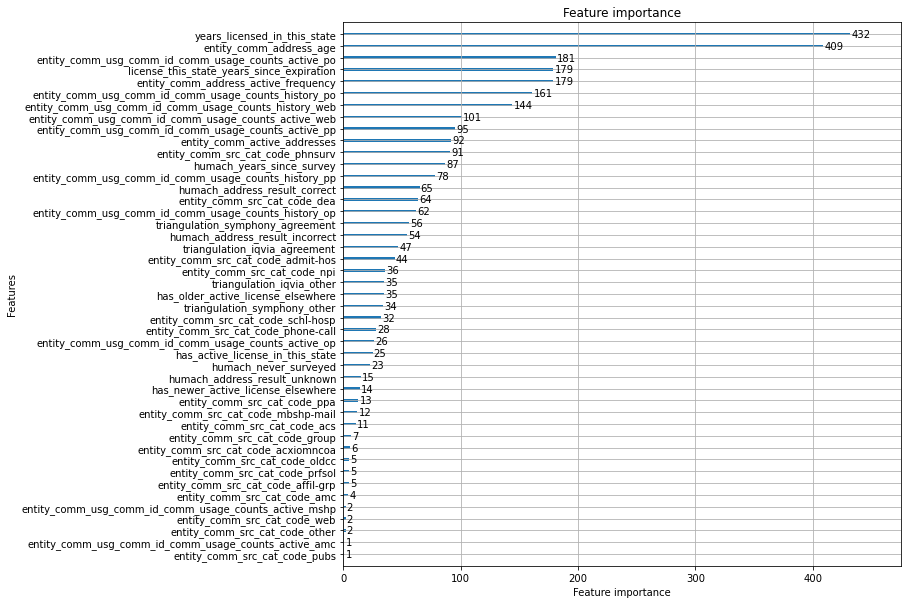

In [63]:
# plot_importance(cv_lgb.best_estimator_, figsize=(10, 10))

In [64]:
# train a new model on all training data with the best model's params

In [65]:
#cv_lgb.best_params_

{'pos_bagging_fraction': 1.0,
 'num_leaves': 31,
 'neg_bagging_fraction': 0.8,
 'min_child_weight': 0.001,
 'metric': 'auc',
 'learning_rate': 0.07,
 'feature_fraction': 0.6,
 'bagging_fraction': 1}

In [66]:
#model = LGBMClassifier(**cv_lgb.best_params_)

In [67]:
#model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


LGBMClassifier(bagging_fraction=1, feature_fraction=0.6, learning_rate=0.07,
               metric='auc', neg_bagging_fraction=0.8,
               pos_bagging_fraction=1.0)

<AxesSubplot:>

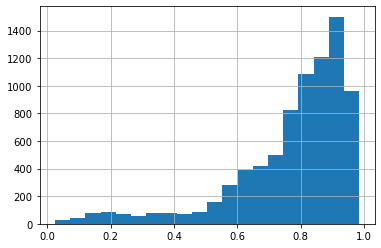

In [68]:
y_pred = [p[1] for p in model.predict_proba(X_test)]

pd.Series(y_pred).hist(bins=20)

In [69]:
#evaluate_model_predictions([p[1] for p in model.predict_proba(X_test)], y_test)

Accuracy:	0.8025
Precision:	0.8122
Recall:		0.9671
ROC_AUC:	0.7666


(0.8024984384759525,
 0.8121848166825678,
 0.9670561506004544,
 0.7665556207748012)

In [71]:
# model.fit(train, labels)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMClassifier(bagging_fraction=0.5, feature_fraction=1.0, learning_rate=0.07,
               metric='auc', min_child_weight=1, neg_bagging_fraction=0.8,
               num_leaves=15, pos_bagging_fraction=0.5)

In [71]:
str(today.date())

'2022-08-16'

In [53]:
today = '2022-11-06'

In [54]:
def save_model(mdl, save_name=f'model_{str(today)}.pkl'):
    pk.dump(mdl, open(save_name, 'wb'))


In [55]:
#save_model(model)

### Another model - RandomForest

In [77]:
"""
parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 12],
    "min_samples_leaf" : [18, 19, 20],
    "min_samples_split" : [8, 9, 10]
}


RFC_Model = RandomForestClassifier()
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Score : ', RFC_grid.best_score_)"""

Best Parameters :  {'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 9, 'n_estimators': 25}

Best Score :  0.8017176764522173


<AxesSubplot:>

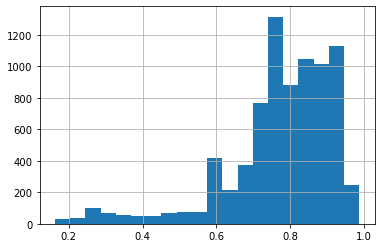

In [79]:
#y_pred = [p[1] for p in RFC_grid.best_estimator_.predict_proba(X_test)]

#pd.Series(y_pred).hist(bins=20)

In [87]:
#std = np.std([RFC_grid.best_estimator_.feature_importances_ for tree in RFC_grid.best_estimator_.estimators_], axis=0)

In [95]:
#std

array([2.77555756e-17, 1.73472348e-18, 6.93889390e-18, 1.30104261e-18,
       0.00000000e+00, 6.50521303e-19, 0.00000000e+00, 0.00000000e+00,
       8.67361738e-19, 0.00000000e+00, 1.35525272e-20, 0.00000000e+00,
       8.13151629e-20, 0.00000000e+00, 5.20417043e-18, 3.38813179e-21,
       0.00000000e+00, 8.13151629e-20, 0.00000000e+00, 0.00000000e+00,
       1.08420217e-19, 0.00000000e+00, 6.50521303e-19, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.73472348e-18, 1.35525272e-20,
       0.00000000e+00, 6.93889390e-18, 0.00000000e+00, 8.47032947e-22,
       0.00000000e+00, 6.77626358e-21, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.93889390e-18,
       6.93889390e-18, 0.00000000e+00, 0.00000000e+00, 6.77626358e-21,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.77626358e-21,
       0.00000000e+00, 0.00000000e+00, 2.08166817e-17, 6.93889390e-18,
      

In [104]:
#forest_importances.to_csv('rf_importances.csv')

C:\Users\Garrett\AppData\Local\Temp/ipykernel_61588/1518033307.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


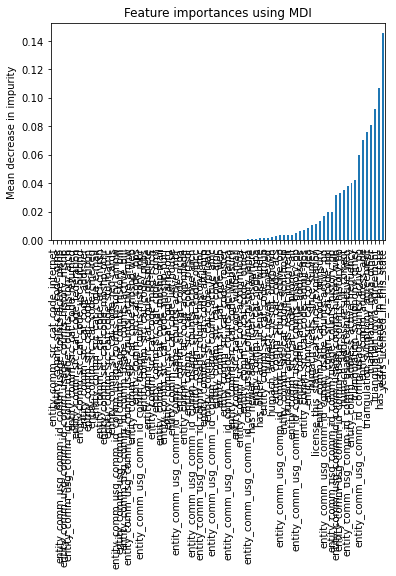

In [97]:
"""imp = RFC_grid.best_estimator_.feature_importances_

forest_importances = pd.Series(imp, index=X_test.columns).sort_values()

#forest_importances = forest_importances.tail(20)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()"""

In [56]:
X_train.columns.values

array(['entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfsol', 'entity_comm_src_cat_code_ncoa',
       'entity_comm_src_cat_code_other',
       'entity_comm_src_cat_code_admit-hos',
       'entity_comm_src_cat_code_group', 'entity_comm_src_cat_code_pps',
       'entity_comm_src

In [106]:
#evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.796
Precision:	0.8009
Recall:		0.9781
ROC_AUC:	0.7573


(0.7960024984384759,
 0.8009302325581396,
 0.9780915287244402,
 0.7572667653232499)

In [62]:
#evaluate_model_predictions([p[1] for p in RFC_grid.best_estimator_.predict_proba(X_test)], y_test)

Accuracy:	0.7951
Precision:	0.8002
Recall:		0.9781
ROC_AUC:	0.7533


(0.7951280449718926, 0.800185873605948, 0.9780915287244402, 0.7532584233649502)

In [130]:
#rf = RFC_grid.best_estimator_

### Another model - XGBoost

In [57]:

param_grid = {'n_estimators': [10, 25, 48, 75, 96, 151],
              'learning_rate': [0.2, 0.15, 0.1, 0.05],
              'eval_metric': ['mlogloss']}


grid = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
best_params = grid.best_params_
print('Best score of cross validation: {:.2f}'.format(grid.best_score_))
print('Best parameters:', best_params)


xgb = XGBClassifier()
xgb.set_params(**best_params)
xgb.fit(X_train, y_train)

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Garrett\AppData\Roaming\Python\Python38\sit

Best score of cross validation: 0.81
Best parameters: {'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'n_estimators': 75}
Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [59]:
import xgboost

In [60]:
xgboost.__version__

'1.5.2'

In [66]:
xgb_savefile = f'model_xgb_{str(today)[:10]}.pkl'
xgb_savefile


'model_xgb_2022-11-06.pkl'

In [61]:
with open(f'model_xgb_{str(today)[:10]}.pkl', 'wb') as f:
    pk.dump(xgb, f)

In [67]:
xgb = pk.load(open('model_xgb_2022-11-06.pkl', 'rb'))

<AxesSubplot:>

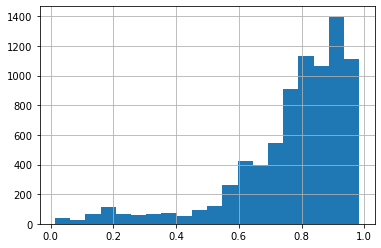

In [68]:
y_pred = [p[1] for p in xgb.predict_proba(X_test)]

pd.Series(y_pred).hist(bins=20)

In [69]:

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [70]:
xgb_importances = xgb.get_booster().get_score(importance_type='total_gain')
xgb_importances

{'entity_comm_address_age': 4461.75732421875,
 'entity_comm_active_addresses': 494.8714294433594,
 'entity_comm_address_active_frequency': 1554.37646484375,
 'entity_comm_src_cat_code_phone-call': 147.3911895751953,
 'entity_comm_src_cat_code_amc': 7.2661848068237305,
 'entity_comm_src_cat_code_ppa': 26.45979118347168,
 'entity_comm_src_cat_code_mfload': 0.5025043487548828,
 'entity_comm_src_cat_code_mbshp-mail': 15.967294692993164,
 'entity_comm_src_cat_code_acs': 34.8651237487793,
 'entity_comm_src_cat_code_roster': 1.4742794036865234,
 'entity_comm_src_cat_code_white-mail': 1.6542892456054688,
 'entity_comm_src_cat_code_list-house': 0.4981689453125,
 'entity_comm_src_cat_code_dea': 215.3610382080078,
 'entity_comm_src_cat_code_affil-grp': 11.588369369506836,
 'entity_comm_src_cat_code_acxiomncoa': 17.66832733154297,
 'entity_comm_src_cat_code_prfsol': 11.997206687927246,
 'entity_comm_src_cat_code_admit-hos': 634.7872314453125,
 'entity_comm_src_cat_code_group': 9.915702819824219,
 

In [71]:
xgb_imp = pd.Series(xgb_importances)

In [72]:
xgb_imp.to_csv('xgb_imp.csv')

In [73]:
xgb_imp = xgb_imp.sort_values()

<BarContainer object of 45 artists>

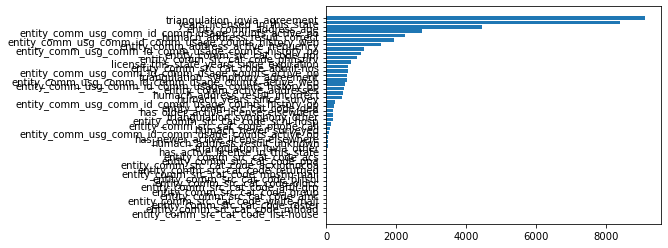

In [74]:
plt.barh(xgb_imp.index, xgb_imp)

In [75]:

evaluate_model_predictions([p[1] for p in xgb.predict_proba(X_test)], y_test)

Accuracy:	0.8012
Precision:	0.8109
Recall:		0.9674
ROC_AUC:	0.7664


(0.8012492192379763,
 0.8109100802611889,
 0.9673807205452775,
 0.7664046948699105)

In [85]:
def predict_ensemble(predictors: list, data):
    prediction_sets = []
    
    for predictor in predictors:
        predictions = [p[1] for p in predictor.predict_proba(data)]
        prediction_sets.append(predictions)
    
    avgs = []
    for i in range(data.shape[0]):
        vals = [p[i] for p in prediction_sets]
        avgs.append(get_mean_predictions(vals))
    return avgs
    
def get_mean_predictions(predictions):
    n = len(predictions)
    return sum(predictions) / n

In [134]:
get_mean_predictions([.5, .5, 1])

0.6666666666666666

In [154]:
rf = RFC_grid.best_estimator_

In [155]:
predictors = [cv_lgb, rf, xgb]

ensemble_predictions = predict_ensemble(predictors, X_test)



In [136]:
evaluate_model_predictions(ensemble_predictions, y_test)

Accuracy:	0.8017
Precision:	0.8085
Recall:		0.9729
ROC_AUC:	0.7676


(0.8017489069331668, 0.8084962913014161, 0.9728984096072704, 0.767556407456268)

In [137]:
# skip RF?
predictors = [
    cv_lgb, 
    #rf, 
    xgb
]

ensemble_predictions_test = predict_ensemble(predictors, X_test)

evaluate_model_predictions(ensemble_predictions_test, y_test)

Accuracy:	0.8014
Precision:	0.8105
Recall:		0.9684
ROC_AUC:	0.7676


(0.8013741411617739, 0.8105134474327629, 0.9683544303797469, 0.76755693578499)

<AxesSubplot:>

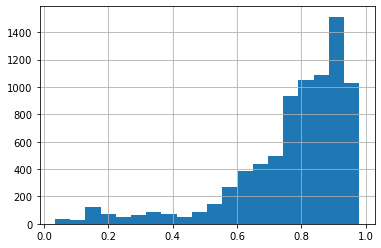

In [138]:
pd.Series(ensemble_predictions_test).hist(bins=20)

In [139]:
train['humach_address_result_correct'].sum()

4230.0

# Apply Model to Pop.

In [86]:
%pwd

'C:\\Users\\Garrett\\PycharmProjects\\AMA\\hs-datalabs\\Source\\Python\\datalabs\\analysis\\address\\scoring\\training'

In [38]:
file_pop = '../etl/aggregate_out__2022-08-16.txt'

pop = pd.read_csv(file_pop, sep='|', dtype=str)

pop.head()

,me,entity_id,comm_id,address_key,state_cd,key,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_group,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_web,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_lock_box,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_acxiom,entity_comm_src_cat_code_polo,entity_comm_src_cat_code_advr,entity_comm_src_cat_code_eci,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_acxiomplus,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_ppma,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_cgmt-exc,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_outreach,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_mbshp-phon,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_interact,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_per,entity_comm_src_cat_code_coa-ps,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_pe,entity_comm_usg_comm_id_comm_usage_counts_active_pf,entity_comm_usg_comm_id_comm_usage_counts_active_pv,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_pe,entity_comm_usg_comm_id_comm_usage_counts_history_pf,entity_comm_usg_comm_id_comm_usage_counts_history_mr,entity_comm_usg_comm_id_comm_usage_counts_history_pv,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_result_unknown,humach_address_result_correct,humach_address_result_in

In [39]:
info_cols

['me',
 'entity_id',
 'comm_id',
 'address_key',
 'state_cd',
 'survey_date',
 'comments',
 'office_address_verified_updated',
 'status']

In [40]:
info_pop = [c for c in info_cols if c in pop.columns]
info_pop

['me', 'entity_id', 'comm_id', 'address_key', 'state_cd']

In [41]:
pop_features = pop.set_index(info_pop)

pop_features.head()

key  \
me          entity_id comm_id address_key                 state_cd                                            
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL               00102000013_1025 7TH AVE N_33705   
                      727664  700 6TH ST S_33701          FL                 00102000013_700 6TH ST S_33701   
                      6625144 1501 PASADENA AVE S_33707   FL          00102000013_1501 PASADENA AVE S_33707   
                      6616913 810 SAINT VINCENTS DR_35205 AL        00102000013_810 SAINT VINCENTS DR_35205   
                      9127102 8711 BRYAN DAIRY RD_33777   FL          00102000013_8711 BRYAN DAIRY RD_33777   

                                                                   entity_comm_address_age  \
me          entity_id comm_id address_key                 state_cd                           
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL            15.898630136986302   
                      727664  700 6TH ST S_33701          FL            21.263013698630136   
                      6625144 1501 PASADENA AVE S_33707   FL            15.684931506849315   
                      6616913 810 SAINT VINCENTS DR_35205 AL            12.405479452054795   
                      9127102 8711 BRYAN DAIRY RD_33777   FL            18.427397260273974   

                                                                   entity_comm_active_addresses  \
me          entity_id comm_id address_key                 state_cd                                
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL                                1.0   
                      727664  700 6TH ST S_33701          FL                                1.0   
                      6625144 1501 PASADENA AVE S_33707   FL                                1.0   
                      6616913 810 SAINT VINCENTS DR_35205 AL                                1.0   
                      9127102 8711 BRYAN DAIRY RD_33777   FL                                1.0   

                                                                   entity_comm_address_active_frequency  \
me          entity_id comm_id address_key                 state_cd                                        
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL                                        0.0   
                      727664  700 6TH ST S_33701          FL                                        1.0   
                      6625144 1501 PASADENA AVE S_33707   FL                                       12.0   
                      6616913 810 SAINT VINCENTS DR_35205 AL                                       42.0   
                      9127102 8711 BRYAN DAIRY RD_33777   FL                                        0.0   

                                                                   entity_comm_src_cat_code_roster  \
me          entity_id comm_id address_key                 state_cd                                   
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL                                     0   
                      727664  700 6TH ST S_33701          FL                                     0   
                      6625144 1501 PASADENA AVE S_33707   FL                                     0   
                      6616913 810 SAINT VINCENTS DR_35205 AL                                     0   
                      9127102 8711 BRYAN DAIRY RD_33777   FL                                     0   

                                                                   entity_comm_src_cat_code_obsolete  \
me          entity_id comm_id address_key                 state_cd                                     
00102000013 1234580   4744607 1025 7TH AVE N_33705        FL                                       0   
                      727664  700 6TH ST S_33701          FL                                       0   
                      6625144 1501 PASADENA AVE S_33707   FL                                

In [42]:
pop_features['triangulation_iqvia_agreement'].value_counts()

0    3419741
1     955479
Name: triangulation_iqvia_agreement, dtype: int64

In [43]:
fillmax = ['entity_comm_address_age', 'humach_years_since_survey']
fillneg1 = ['license_this_state_years_since_expiration', 'years_licensed_in_this_state']
fill1 = ['humach_never_surveyed']


for col in fillmax:
    mx = pop_features[col].dropna().max()
    pop_features[col].fillna(mx, inplace=True)
for col in fillneg1:
    pop_features[col].fillna(-1, inplace=True)
for col in fill1:
    pop_features[col].fillna(1, inplace=True)


In [44]:
for col in to_scale:
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(pop_features[[col]]).reshape(1, -1)[0]
    pop_features[col] = scaled

In [45]:
pop_features

key  \
me          entity_id comm_id  address_key                 state_cd                                            
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL               00102000013_1025 7TH AVE N_33705   
                      727664   700 6TH ST S_33701          FL                 00102000013_700 6TH ST S_33701   
                      6625144  1501 PASADENA AVE S_33707   FL          00102000013_1501 PASADENA AVE S_33707   
                      6616913  810 SAINT VINCENTS DR_35205 AL        00102000013_810 SAINT VINCENTS DR_35205   
                      9127102  8711 BRYAN DAIRY RD_33777   FL          00102000013_8711 BRYAN DAIRY RD_33777   
...                                                                                                      ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH              96501960036_730 W MARKET ST_45801   
                      3813070  800 SPRUCE ST_19107         PA                96501960036_800 SPRUCE ST_19107   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                96501960044_142 S MAIN ST_24541   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC        96501960052_1 MEDICAL CENTER BLVD_27157   
                      15602604 17420 NORTON AVE_44107      OH             96501960052_17420 NORTON AVE_44107   

                                                                     entity_comm_address_age  \
me          entity_id comm_id  address_key                 state_cd                            
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL                       0.129566   
                      727664   700 6TH ST S_33701          FL                       0.173283   
                      6625144  1501 PASADENA AVE S_33707   FL                       0.127824   
                      6616913  810 SAINT VINCENTS DR_35205 AL                       0.101099   
                      9127102  8711 BRYAN DAIRY RD_33777   FL                       0.150174   
...                                                                                      ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH                       0.034183   
                      3813070  800 SPRUCE ST_19107         PA                       0.000871   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                       0.039832   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC                       0.030276   
                      15602604 17420 NORTON AVE_44107      OH                       0.086139   

                                                                    entity_comm_active_addresses  \
me          entity_id comm_id  address_key                 state_cd                                
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL                                1.0   
                      727664   700 6TH ST S_33701          FL                                1.0   
                      6625144  1501 PASADENA AVE S_33707   FL                                1.0   
                      6616913  810 SAINT VINCENTS DR_35205 AL                                1.0   
                      9127102  8711 BRYAN DAIRY RD_33777   FL                                1.0   
...                                                                                          ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH                                1.0   
                      3813070  800 SPRUCE ST_19107         PA                                1.0   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                                1.0   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC                                1.0   
                      15602604 17420 NORTON AVE_44107      OH                                1.0   

                                                                     entity_comm_address_active_fr

In [46]:
# pop_features_nh = pop_features[non_humach]

In [47]:
pop_features.columns

Index(['key', 'entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_roster', 'entity_comm_src_cat_code_obsolete',
       'entity_comm_src_cat_code_phone-call', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_other', 'entity_comm_src_cat_code_acs',
       ...
       'license_this_state_years_since_expiration',
       'humach_years_since_survey', 'humach_never_surveyed',
       'humach_address_result_unknown', 'humach_address_result_correct',
       'humach_address_result_incorrect', 'triangulation_iqvia_agreement',
       'triangulation_iqvia_other', 'triangulation_symphony_agreement',
       'triangulation_symphony_other'],
      dtype='object', length=108)

In [48]:
pop_features['triangulation_iqvia_agreement'].dropna().iloc[0]

'0'

In [76]:
pd.__version__

'1.3.3'

In [77]:
import tqdm as tq
from tqdm import tqdm

In [78]:
tq.__version__

'4.62.3'

In [79]:
import numpy as np

np.__version__

'1.21.5'

In [49]:
#pop_features['triangulation_iqvia_agreement'] = (pop_features['triangulation_iqvia_agreement'].astype(str) == 'True').astype(int)
#pop_features['triangulation_iqvia_other'] = (pop_features['triangulation_iqvia_other'].astype(str) == 'True').astype(int)
#pop_features['triangulation_symphony_agreement'] = (pop_features['triangulation_symphony_agreement'].astype(str) == 'True').astype(int)
#pop_features['triangulation_symphony_other'] = (pop_features['triangulation_symphony_other'].astype(str) == 'True').astype(int)

In [50]:
train['triangulation_iqvia_agreement'].value_counts()

0    24829
1    15196
Name: triangulation_iqvia_agreement, dtype: int64

In [51]:
pop_features['triangulation_iqvia_agreement'].value_counts()

0    3419741
1     955479
Name: triangulation_iqvia_agreement, dtype: int64

In [52]:
pop_features['entity_comm_address_age']

me           entity_id  comm_id   address_key                  state_cd
00102000013  1234580    4744607   1025 7TH AVE N_33705         FL          0.129566
                        727664    700 6TH ST S_33701           FL          0.173283
                        6625144   1501 PASADENA AVE S_33707    FL          0.127824
                        6616913   810 SAINT VINCENTS DR_35205  AL          0.101099
                        9127102   8711 BRYAN DAIRY RD_33777    FL          0.150174
                                                                             ...   
96501960036  27921214   8355689   730 W MARKET ST_45801        OH          0.034183
                        3813070   800 SPRUCE ST_19107          PA          0.000871
96501960044  28518902   7057733   142 S MAIN ST_24541          VA          0.039832
96501960052  39355091   3537863   1 MEDICAL CENTER BLVD_27157  NC          0.030276
                        15602604  17420 NORTON AVE_44107       OH          0.086139
Name

In [53]:
del pop_features['key']

In [54]:
for col in pop_features.columns:
    if pop_features[col].apply(lambda x: isinstance(x, str)).any():
        #print(col)
        pop_features[col] = pop_features[col].astype(float)

In [55]:

for col in pop_features.columns.values:
    if col not in info_cols:
        pop_features[col].fillna(0, inplace=True)
pop_features

entity_comm_address_age  \
me          entity_id comm_id  address_key                 state_cd                            
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL                       0.129566   
                      727664   700 6TH ST S_33701          FL                       0.173283   
                      6625144  1501 PASADENA AVE S_33707   FL                       0.127824   
                      6616913  810 SAINT VINCENTS DR_35205 AL                       0.101099   
                      9127102  8711 BRYAN DAIRY RD_33777   FL                       0.150174   
...                                                                                      ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH                       0.034183   
                      3813070  800 SPRUCE ST_19107         PA                       0.000871   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                       0.039832   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC                       0.030276   
                      15602604 17420 NORTON AVE_44107      OH                       0.086139   

                                                                     entity_comm_active_addresses  \
me          entity_id comm_id  address_key                 state_cd                                 
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL                                 1.0   
                      727664   700 6TH ST S_33701          FL                                 1.0   
                      6625144  1501 PASADENA AVE S_33707   FL                                 1.0   
                      6616913  810 SAINT VINCENTS DR_35205 AL                                 1.0   
                      9127102  8711 BRYAN DAIRY RD_33777   FL                                 1.0   
...                                                                                           ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH                                 1.0   
                      3813070  800 SPRUCE ST_19107         PA                                 1.0   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                                 1.0   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC                                 1.0   
                      15602604 17420 NORTON AVE_44107      OH                                 1.0   

                                                                     entity_comm_address_active_frequency  \
me          entity_id comm_id  address_key                 state_cd                                         
00102000013 1234580   4744607  1025 7TH AVE N_33705        FL                                    0.000000   
                      727664   700 6TH ST S_33701          FL                                    0.000574   
                      6625144  1501 PASADENA AVE S_33707   FL                                    0.006893   
                      6616913  810 SAINT VINCENTS DR_35205 AL                                    0.024124   
                      9127102  8711 BRYAN DAIRY RD_33777   FL                                    0.000000   
...                                                                                                   ...   
96501960036 27921214  8355689  730 W MARKET ST_45801       OH                                    0.002872   
                      3813070  800 SPRUCE ST_19107         PA                                    0.036760   
96501960044 28518902  7057733  142 S MAIN ST_24541         VA                                    0.001149   
96501960052 39355091  3537863  1 MEDICAL CENTER BLVD_27157 NC                                    0.014360   
                      15602604 17420 NORTON AVE_44107      OH                                    0.000000   

                                                                     entity_comm_src_cat

In [57]:
used_features = []
for col in pop_features.columns:
    if col not in train.columns:
        print(col)
    else:
        used_features.append(col)

entity_comm_src_cat_code_lock_box
entity_comm_src_cat_code_acxiom
entity_comm_src_cat_code_polo
entity_comm_src_cat_code_advr
entity_comm_src_cat_code_eci
entity_comm_src_cat_code_medec
entity_comm_src_cat_code_acxiomplus
entity_comm_src_cat_code_ppma
entity_comm_src_cat_code_cgmt-exc
entity_comm_src_cat_code_outreach
entity_comm_src_cat_code_mbshp-phon
entity_comm_src_cat_code_fast-track
entity_comm_src_cat_code_interact
entity_comm_src_cat_code_yellow
entity_comm_src_cat_code_per
entity_comm_src_cat_code_coa-ps
entity_comm_usg_comm_id_comm_usage_counts_active_pe
entity_comm_usg_comm_id_comm_usage_counts_active_pf
entity_comm_usg_comm_id_comm_usage_counts_active_pv
entity_comm_usg_comm_id_comm_usage_counts_history_pe
entity_comm_usg_comm_id_comm_usage_counts_history_pf
entity_comm_usg_comm_id_comm_usage_counts_history_mr
entity_comm_usg_comm_id_comm_usage_counts_history_pv


############## entity_comm_address_age ##############
############## entity_comm_address_age ##############
############## entity_comm_address_age ##############
AxesSubplot(0.125,0.125;0.775x0.755)


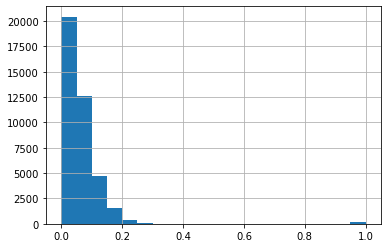

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


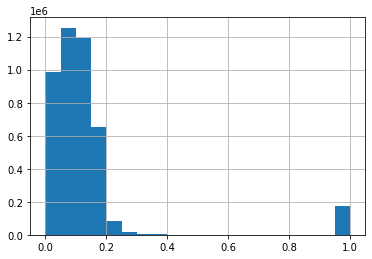




############## entity_comm_active_addresses ##############
############## entity_comm_active_addresses ##############
############## entity_comm_active_addresses ##############
AxesSubplot(0.125,0.125;0.775x0.755)


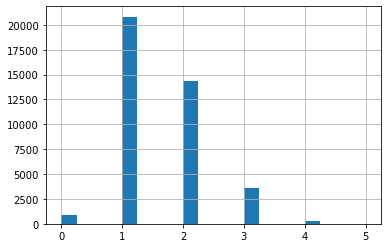

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


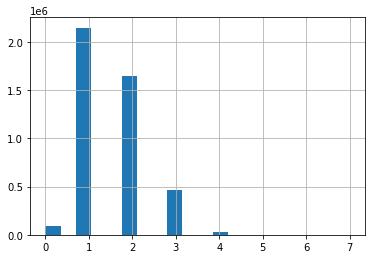




############## entity_comm_address_active_frequency ##############
############## entity_comm_address_active_frequency ##############
############## entity_comm_address_active_frequency ##############
AxesSubplot(0.125,0.125;0.775x0.755)


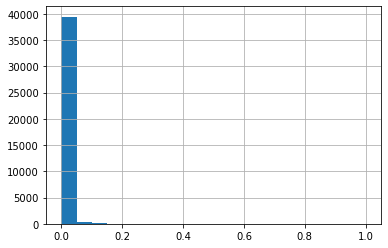

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


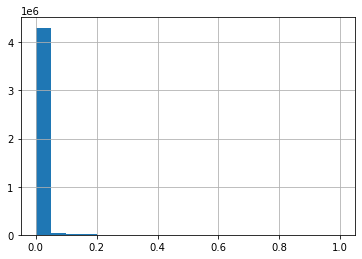




############## entity_comm_src_cat_code_roster ##############
############## entity_comm_src_cat_code_roster ##############
############## entity_comm_src_cat_code_roster ##############
AxesSubplot(0.125,0.125;0.775x0.755)


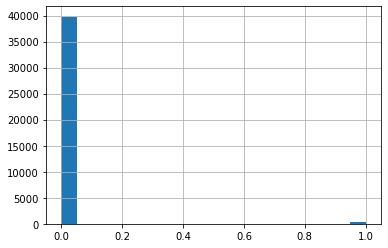

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


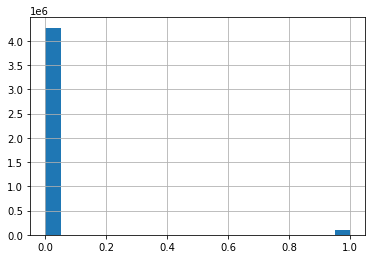




############## entity_comm_src_cat_code_obsolete ##############
############## entity_comm_src_cat_code_obsolete ##############
############## entity_comm_src_cat_code_obsolete ##############
AxesSubplot(0.125,0.125;0.775x0.755)


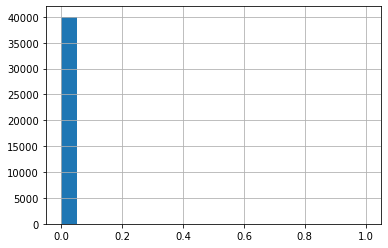

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


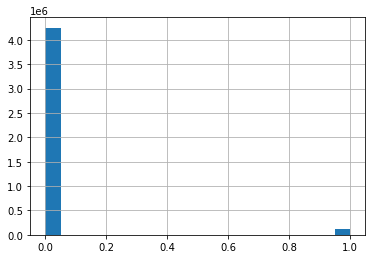




############## entity_comm_src_cat_code_phone-call ##############
############## entity_comm_src_cat_code_phone-call ##############
############## entity_comm_src_cat_code_phone-call ##############
AxesSubplot(0.125,0.125;0.775x0.755)


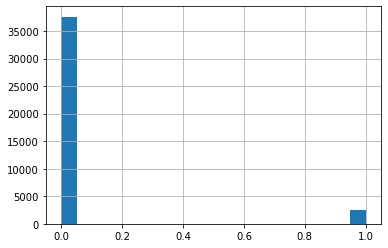

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


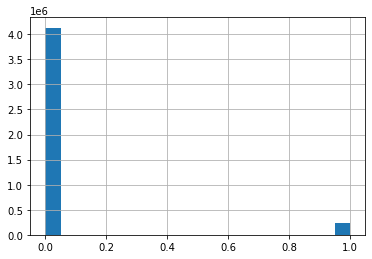




############## entity_comm_src_cat_code_ppa ##############
############## entity_comm_src_cat_code_ppa ##############
############## entity_comm_src_cat_code_ppa ##############
AxesSubplot(0.125,0.125;0.775x0.755)


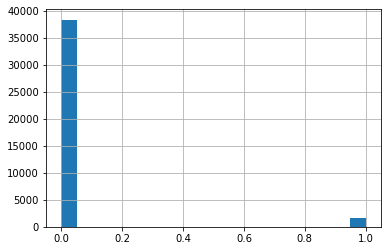

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


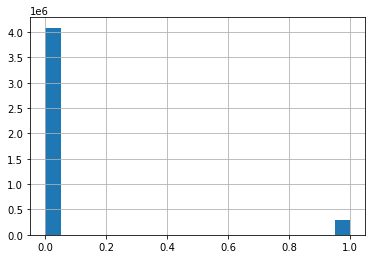




############## entity_comm_src_cat_code_other ##############
############## entity_comm_src_cat_code_other ##############
############## entity_comm_src_cat_code_other ##############
AxesSubplot(0.125,0.125;0.775x0.755)


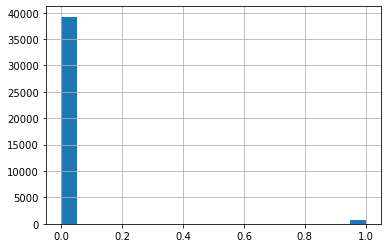

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


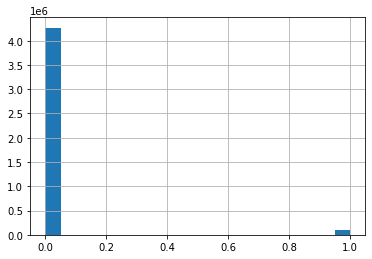




############## entity_comm_src_cat_code_acs ##############
############## entity_comm_src_cat_code_acs ##############
############## entity_comm_src_cat_code_acs ##############
AxesSubplot(0.125,0.125;0.775x0.755)


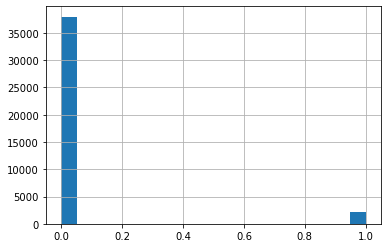

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


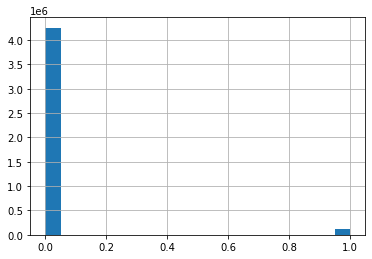




############## entity_comm_src_cat_code_oldcc ##############
############## entity_comm_src_cat_code_oldcc ##############
############## entity_comm_src_cat_code_oldcc ##############
AxesSubplot(0.125,0.125;0.775x0.755)


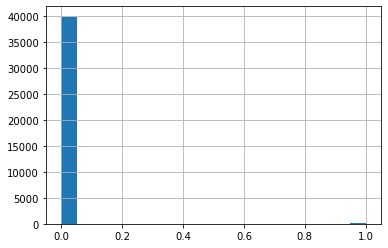

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


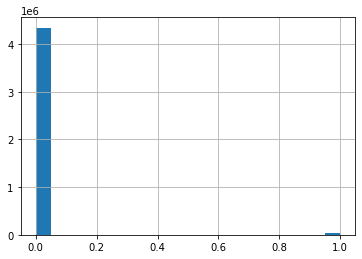




############## entity_comm_src_cat_code_pubs ##############
############## entity_comm_src_cat_code_pubs ##############
############## entity_comm_src_cat_code_pubs ##############
AxesSubplot(0.125,0.125;0.775x0.755)


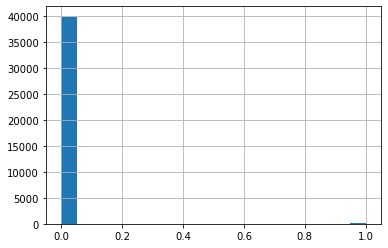

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


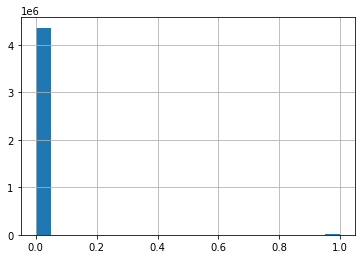




############## entity_comm_src_cat_code_mbshp-mail ##############
############## entity_comm_src_cat_code_mbshp-mail ##############
############## entity_comm_src_cat_code_mbshp-mail ##############
AxesSubplot(0.125,0.125;0.775x0.755)


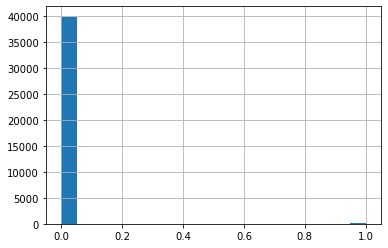

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


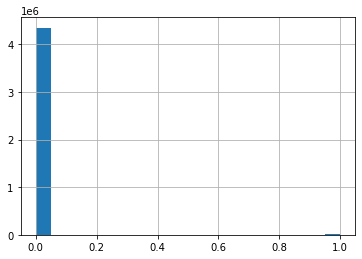




############## entity_comm_src_cat_code_white-mail ##############
############## entity_comm_src_cat_code_white-mail ##############
############## entity_comm_src_cat_code_white-mail ##############
AxesSubplot(0.125,0.125;0.775x0.755)


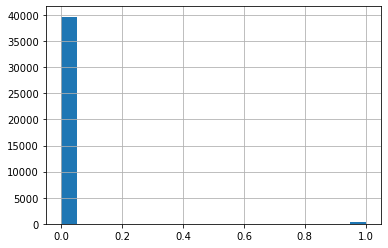

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


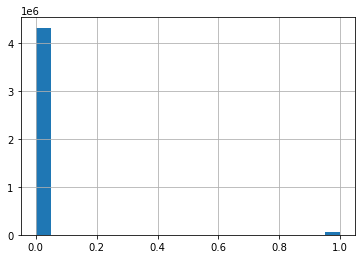




############## entity_comm_src_cat_code_req-cards ##############
############## entity_comm_src_cat_code_req-cards ##############
############## entity_comm_src_cat_code_req-cards ##############
AxesSubplot(0.125,0.125;0.775x0.755)


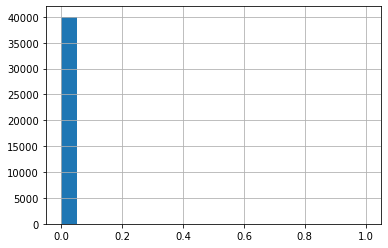

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


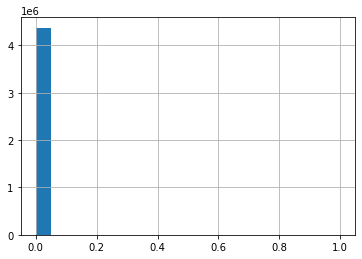




############## entity_comm_src_cat_code_ama-org ##############
############## entity_comm_src_cat_code_ama-org ##############
############## entity_comm_src_cat_code_ama-org ##############
AxesSubplot(0.125,0.125;0.775x0.755)


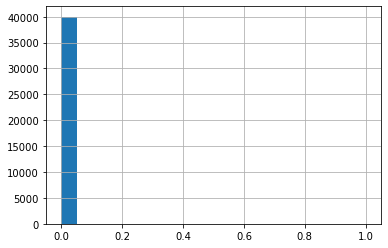

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


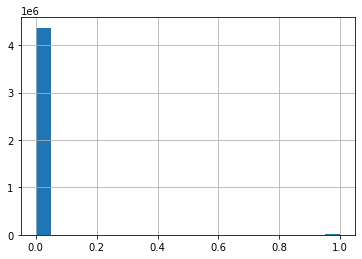




############## entity_comm_src_cat_code_list-house ##############
############## entity_comm_src_cat_code_list-house ##############
############## entity_comm_src_cat_code_list-house ##############
AxesSubplot(0.125,0.125;0.775x0.755)


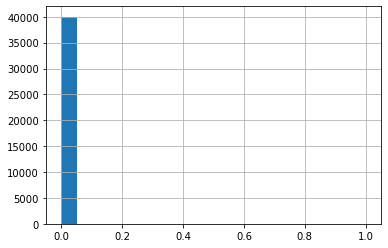

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


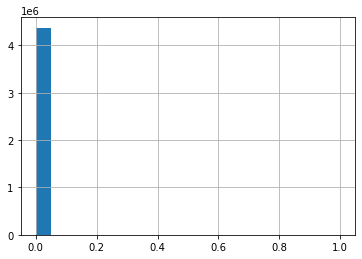




############## entity_comm_src_cat_code_group ##############
############## entity_comm_src_cat_code_group ##############
############## entity_comm_src_cat_code_group ##############
AxesSubplot(0.125,0.125;0.775x0.755)


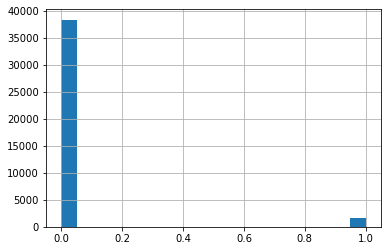

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


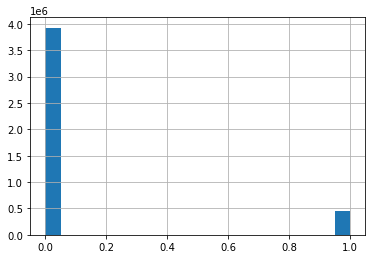




############## entity_comm_src_cat_code_returned ##############
############## entity_comm_src_cat_code_returned ##############
############## entity_comm_src_cat_code_returned ##############
AxesSubplot(0.125,0.125;0.775x0.755)


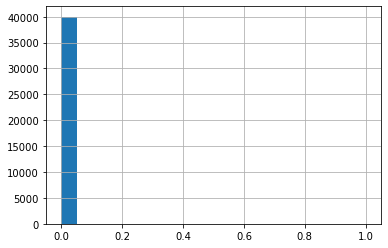

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


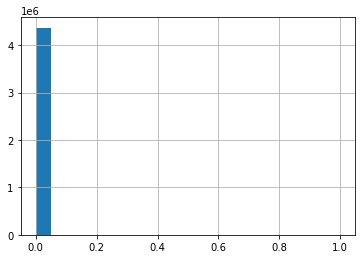




############## entity_comm_src_cat_code_e-mail ##############
############## entity_comm_src_cat_code_e-mail ##############
############## entity_comm_src_cat_code_e-mail ##############
AxesSubplot(0.125,0.125;0.775x0.755)


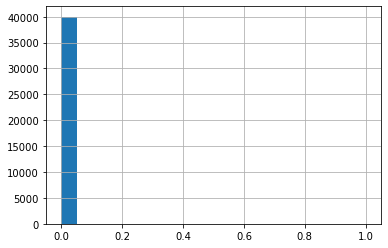

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


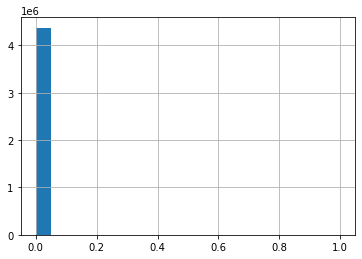




############## entity_comm_src_cat_code_web ##############
############## entity_comm_src_cat_code_web ##############
############## entity_comm_src_cat_code_web ##############
AxesSubplot(0.125,0.125;0.775x0.755)


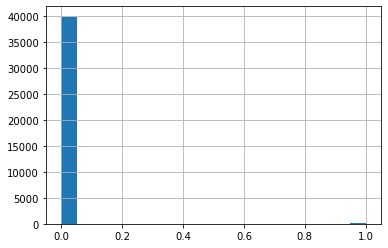

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


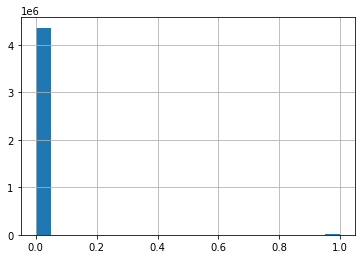




############## entity_comm_src_cat_code_mbshp-web ##############
############## entity_comm_src_cat_code_mbshp-web ##############
############## entity_comm_src_cat_code_mbshp-web ##############
AxesSubplot(0.125,0.125;0.775x0.755)


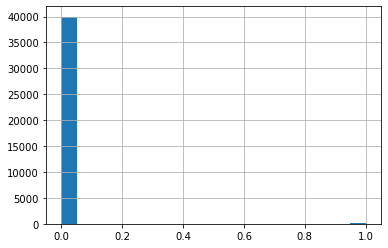

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


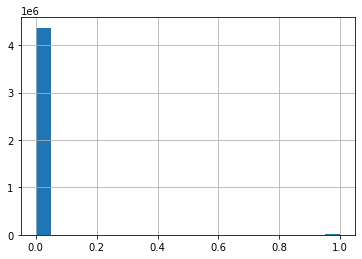




############## entity_comm_src_cat_code_internet ##############
############## entity_comm_src_cat_code_internet ##############
############## entity_comm_src_cat_code_internet ##############
AxesSubplot(0.125,0.125;0.775x0.755)


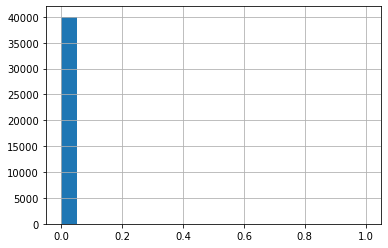

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


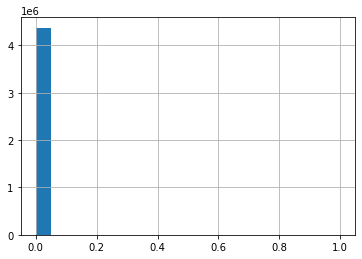




############## entity_comm_src_cat_code_mrkt-rsrch ##############
############## entity_comm_src_cat_code_mrkt-rsrch ##############
############## entity_comm_src_cat_code_mrkt-rsrch ##############
AxesSubplot(0.125,0.125;0.775x0.755)


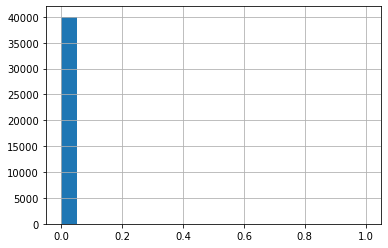

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


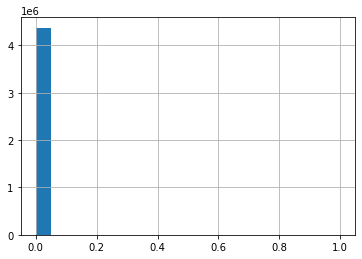




############## entity_comm_src_cat_code_usc-outbnd ##############
############## entity_comm_src_cat_code_usc-outbnd ##############
############## entity_comm_src_cat_code_usc-outbnd ##############
AxesSubplot(0.125,0.125;0.775x0.755)


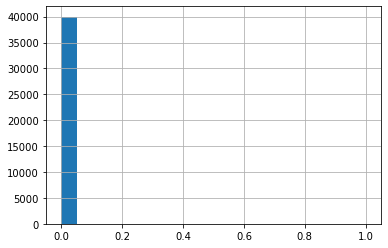

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


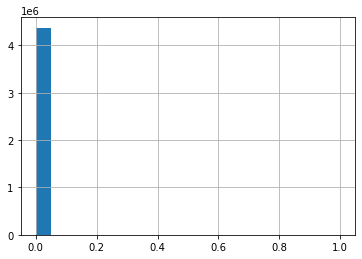




############## entity_comm_src_cat_code_schl-hosp ##############
############## entity_comm_src_cat_code_schl-hosp ##############
############## entity_comm_src_cat_code_schl-hosp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


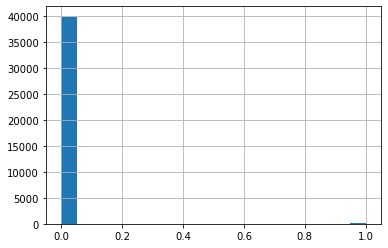

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


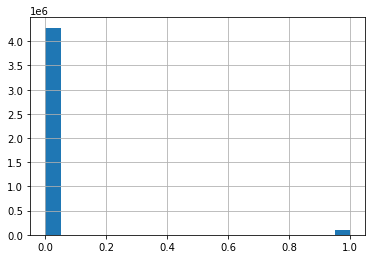




############## entity_comm_src_cat_code_gme ##############
############## entity_comm_src_cat_code_gme ##############
############## entity_comm_src_cat_code_gme ##############
AxesSubplot(0.125,0.125;0.775x0.755)


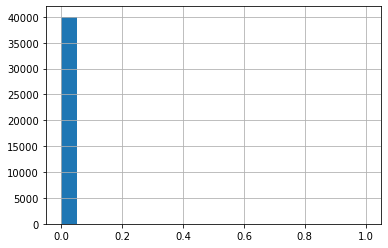

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


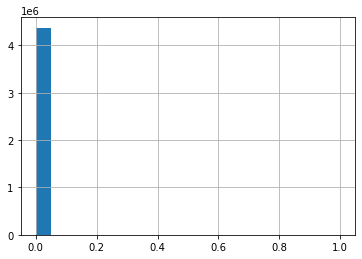




############## entity_comm_src_cat_code_amc ##############
############## entity_comm_src_cat_code_amc ##############
############## entity_comm_src_cat_code_amc ##############
AxesSubplot(0.125,0.125;0.775x0.755)


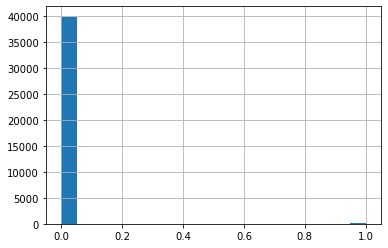

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


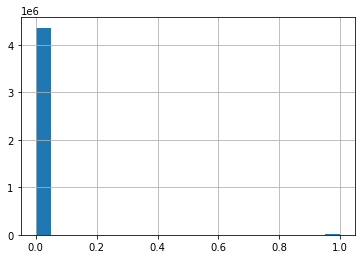




############## entity_comm_src_cat_code_mbshp-othr ##############
############## entity_comm_src_cat_code_mbshp-othr ##############
############## entity_comm_src_cat_code_mbshp-othr ##############
AxesSubplot(0.125,0.125;0.775x0.755)


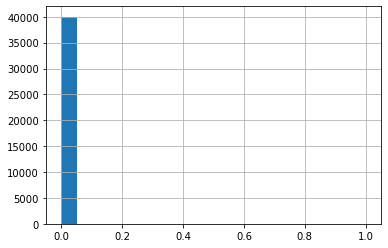

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


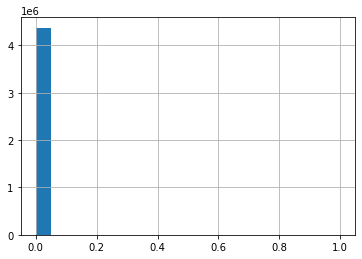




############## entity_comm_src_cat_code_mfload ##############
############## entity_comm_src_cat_code_mfload ##############
############## entity_comm_src_cat_code_mfload ##############
AxesSubplot(0.125,0.125;0.775x0.755)


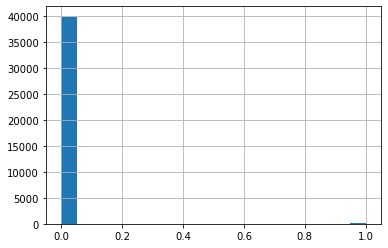

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


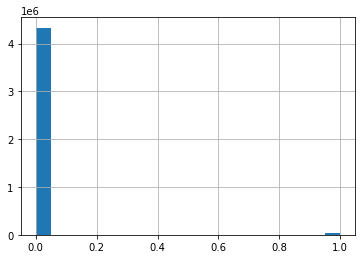




############## entity_comm_src_cat_code_addr-ver ##############
############## entity_comm_src_cat_code_addr-ver ##############
############## entity_comm_src_cat_code_addr-ver ##############
AxesSubplot(0.125,0.125;0.775x0.755)


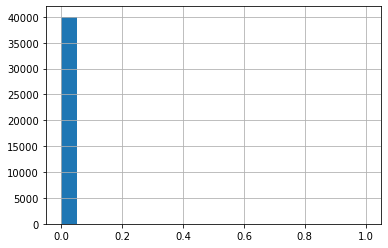

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


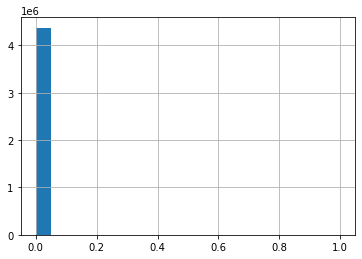




############## entity_comm_src_cat_code_res-tipon ##############
############## entity_comm_src_cat_code_res-tipon ##############
############## entity_comm_src_cat_code_res-tipon ##############
AxesSubplot(0.125,0.125;0.775x0.755)


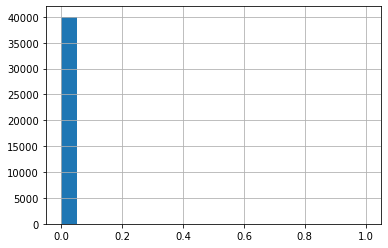

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


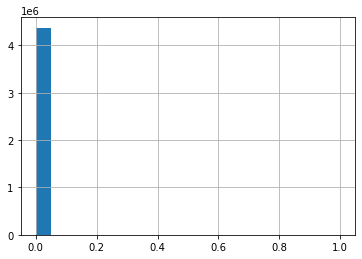




############## entity_comm_src_cat_code_ncoa ##############
############## entity_comm_src_cat_code_ncoa ##############
############## entity_comm_src_cat_code_ncoa ##############
AxesSubplot(0.125,0.125;0.775x0.755)


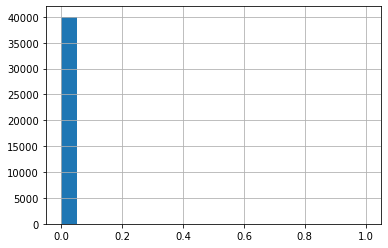

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


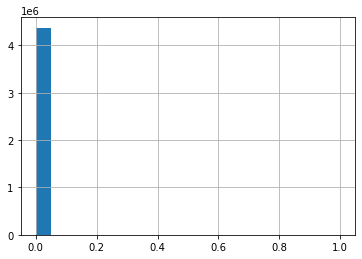




############## entity_comm_src_cat_code_dea ##############
############## entity_comm_src_cat_code_dea ##############
############## entity_comm_src_cat_code_dea ##############
AxesSubplot(0.125,0.125;0.775x0.755)


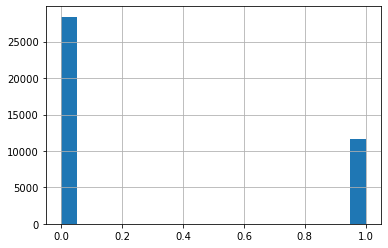

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


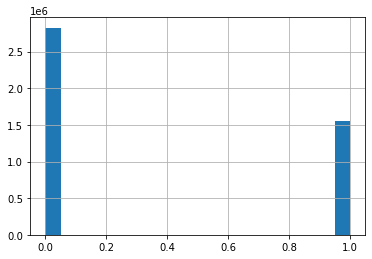




############## entity_comm_src_cat_code_acxiomncoa ##############
############## entity_comm_src_cat_code_acxiomncoa ##############
############## entity_comm_src_cat_code_acxiomncoa ##############
AxesSubplot(0.125,0.125;0.775x0.755)


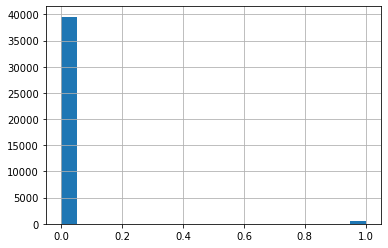

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


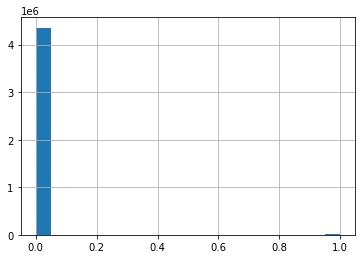




############## entity_comm_src_cat_code_ecf-cnvrsn ##############
############## entity_comm_src_cat_code_ecf-cnvrsn ##############
############## entity_comm_src_cat_code_ecf-cnvrsn ##############
AxesSubplot(0.125,0.125;0.775x0.755)


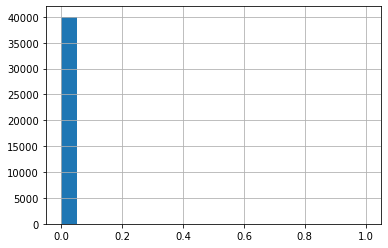

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


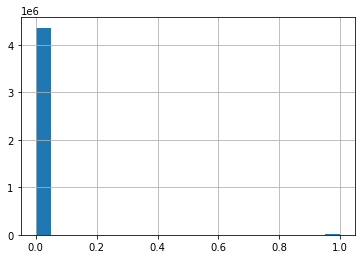




############## entity_comm_src_cat_code_acxiomlode ##############
############## entity_comm_src_cat_code_acxiomlode ##############
############## entity_comm_src_cat_code_acxiomlode ##############
AxesSubplot(0.125,0.125;0.775x0.755)


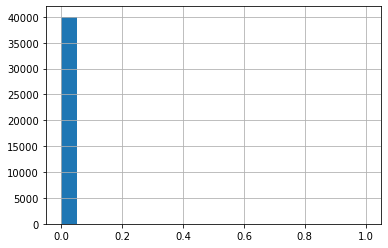

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


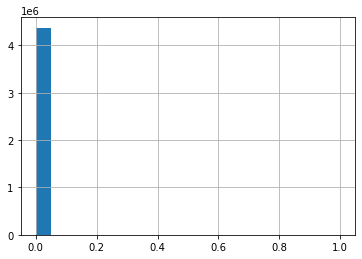




############## entity_comm_src_cat_code_admit-hos ##############
############## entity_comm_src_cat_code_admit-hos ##############
############## entity_comm_src_cat_code_admit-hos ##############
AxesSubplot(0.125,0.125;0.775x0.755)


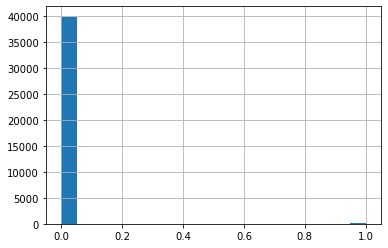

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


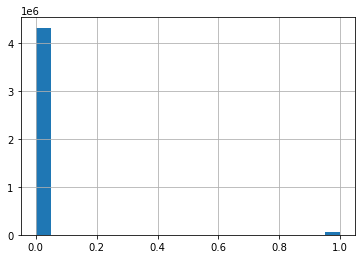




############## entity_comm_src_cat_code_affil-grp ##############
############## entity_comm_src_cat_code_affil-grp ##############
############## entity_comm_src_cat_code_affil-grp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


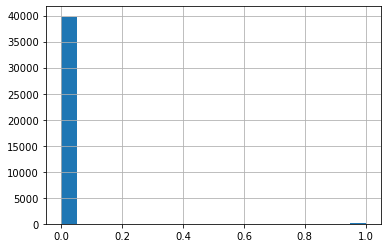

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


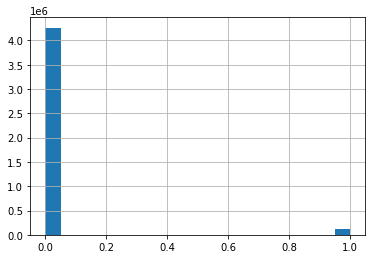




############## entity_comm_src_cat_code_cgmt ##############
############## entity_comm_src_cat_code_cgmt ##############
############## entity_comm_src_cat_code_cgmt ##############
AxesSubplot(0.125,0.125;0.775x0.755)


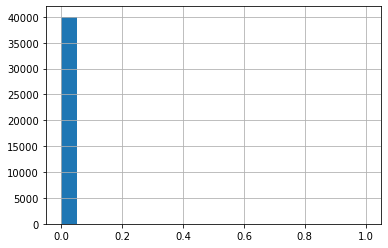

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


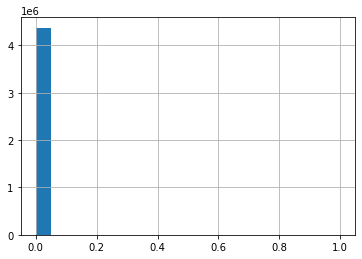




############## entity_comm_src_cat_code_prfsol ##############
############## entity_comm_src_cat_code_prfsol ##############
############## entity_comm_src_cat_code_prfsol ##############
AxesSubplot(0.125,0.125;0.775x0.755)


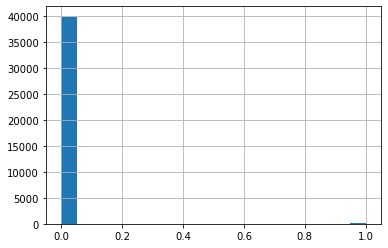

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


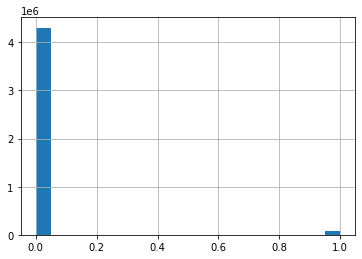




############## entity_comm_src_cat_code_phnsurv ##############
############## entity_comm_src_cat_code_phnsurv ##############
############## entity_comm_src_cat_code_phnsurv ##############
AxesSubplot(0.125,0.125;0.775x0.755)


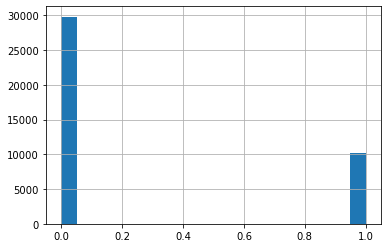

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


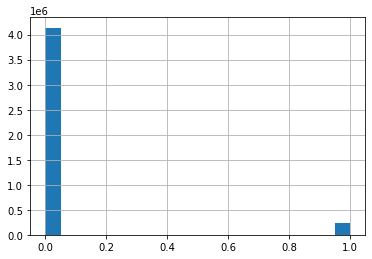




############## entity_comm_src_cat_code_pps ##############
############## entity_comm_src_cat_code_pps ##############
############## entity_comm_src_cat_code_pps ##############
AxesSubplot(0.125,0.125;0.775x0.755)


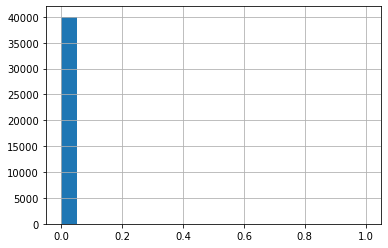

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


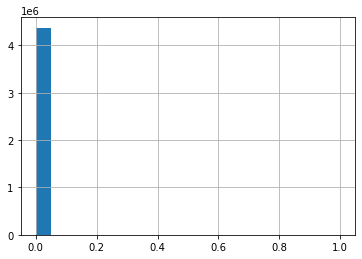




############## entity_comm_src_cat_code_stu-matric ##############
############## entity_comm_src_cat_code_stu-matric ##############
############## entity_comm_src_cat_code_stu-matric ##############
AxesSubplot(0.125,0.125;0.775x0.755)


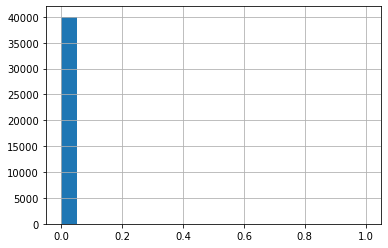

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


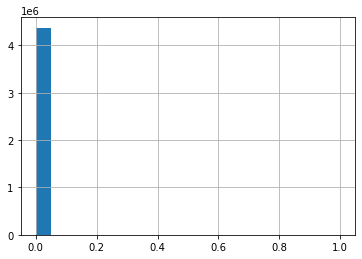




############## entity_comm_src_cat_code_websurv ##############
############## entity_comm_src_cat_code_websurv ##############
############## entity_comm_src_cat_code_websurv ##############
AxesSubplot(0.125,0.125;0.775x0.755)


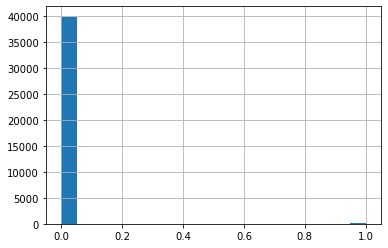

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


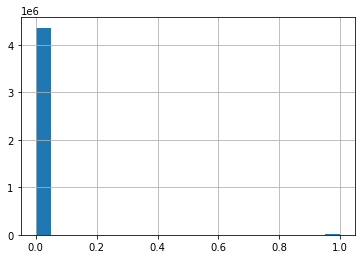




############## entity_comm_src_cat_code_npi ##############
############## entity_comm_src_cat_code_npi ##############
############## entity_comm_src_cat_code_npi ##############
AxesSubplot(0.125,0.125;0.775x0.755)


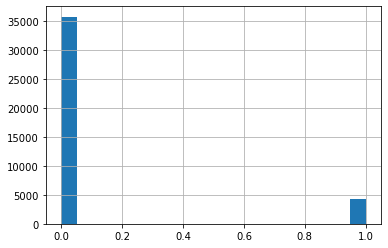

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


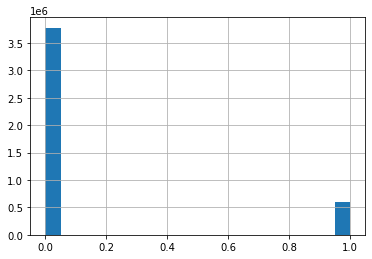




############## entity_comm_src_cat_code_federation ##############
############## entity_comm_src_cat_code_federation ##############
############## entity_comm_src_cat_code_federation ##############
AxesSubplot(0.125,0.125;0.775x0.755)


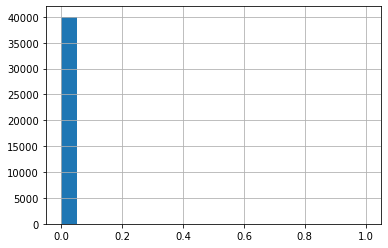

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


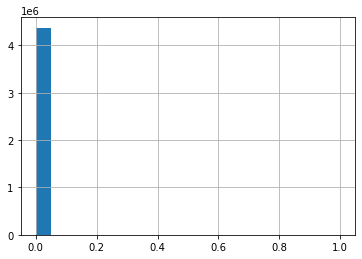




############## entity_comm_src_cat_code_cme-reg ##############
############## entity_comm_src_cat_code_cme-reg ##############
############## entity_comm_src_cat_code_cme-reg ##############
AxesSubplot(0.125,0.125;0.775x0.755)


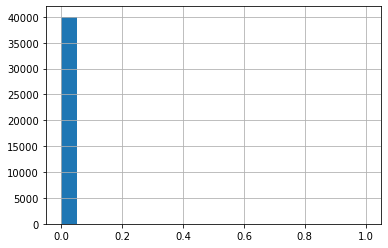

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


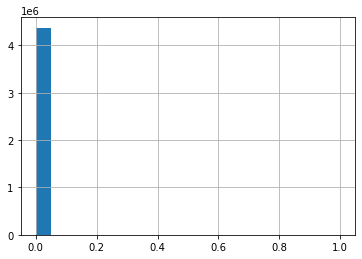




############## entity_comm_src_cat_code_mbshp-purl ##############
############## entity_comm_src_cat_code_mbshp-purl ##############
############## entity_comm_src_cat_code_mbshp-purl ##############
AxesSubplot(0.125,0.125;0.775x0.755)


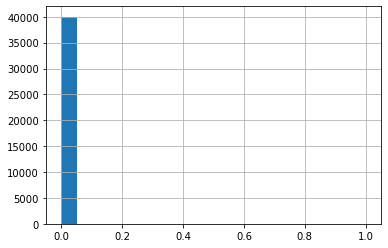

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


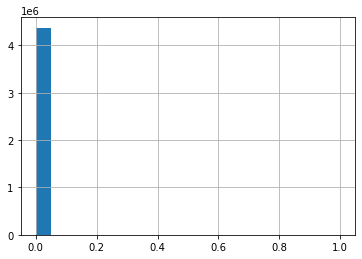




############## entity_comm_usg_comm_id_comm_usage_counts_active_op ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_op ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_op ##############
AxesSubplot(0.125,0.125;0.775x0.755)


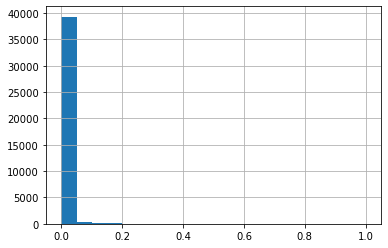

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


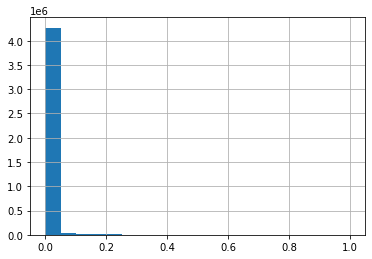




############## entity_comm_usg_comm_id_comm_usage_counts_active_po ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_po ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_po ##############
AxesSubplot(0.125,0.125;0.775x0.755)


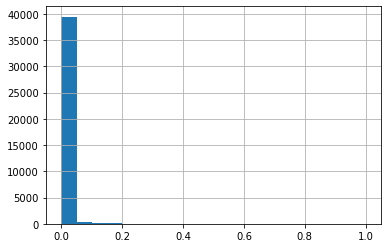

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


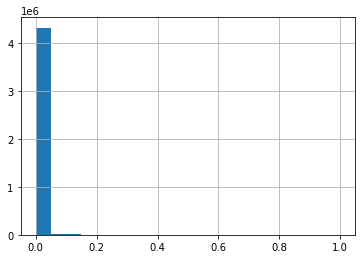




############## entity_comm_usg_comm_id_comm_usage_counts_active_web ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_web ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_web ##############
AxesSubplot(0.125,0.125;0.775x0.755)


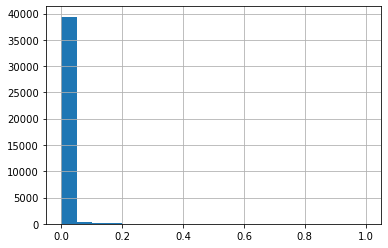

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


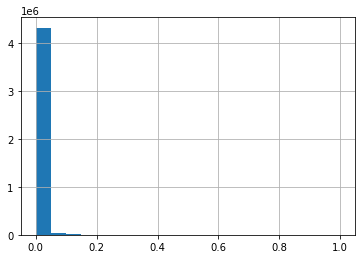




############## entity_comm_usg_comm_id_comm_usage_counts_active_pp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_pp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_pp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


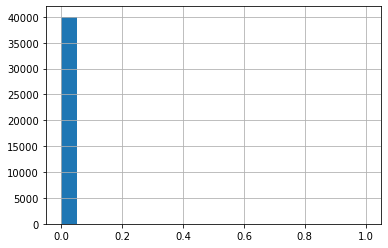

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


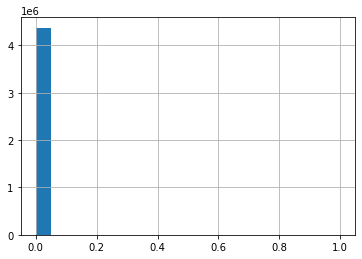




############## entity_comm_usg_comm_id_comm_usage_counts_active_arch ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_arch ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_arch ##############
AxesSubplot(0.125,0.125;0.775x0.755)


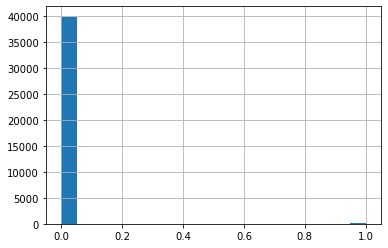

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


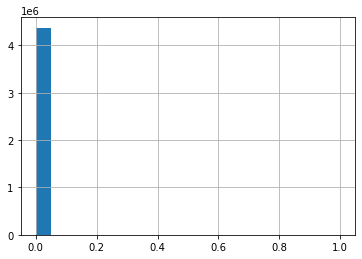




############## entity_comm_usg_comm_id_comm_usage_counts_active_jama ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_jama ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_jama ##############
AxesSubplot(0.125,0.125;0.775x0.755)


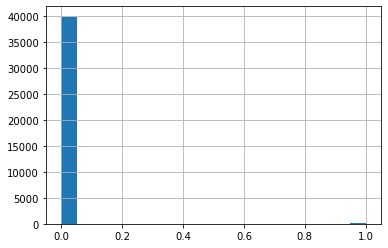

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


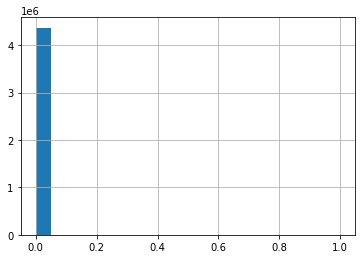




############## entity_comm_usg_comm_id_comm_usage_counts_active_mshp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_mshp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_mshp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


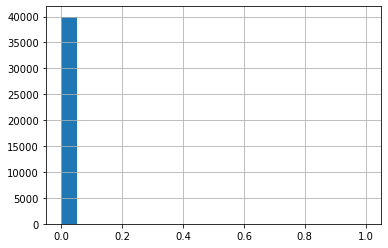

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


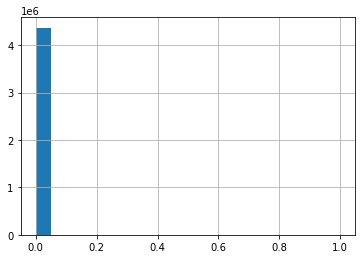




############## entity_comm_usg_comm_id_comm_usage_counts_active_bill ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_bill ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_bill ##############
AxesSubplot(0.125,0.125;0.775x0.755)


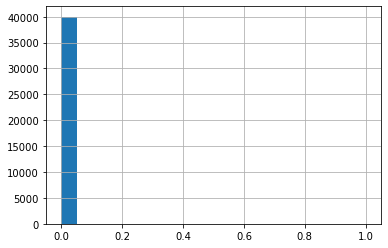

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


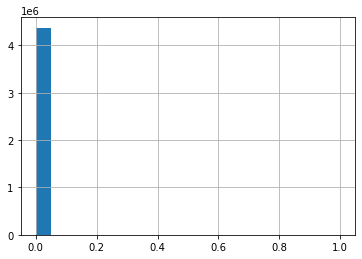




############## entity_comm_usg_comm_id_comm_usage_counts_active_amc ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_amc ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_amc ##############
AxesSubplot(0.125,0.125;0.775x0.755)


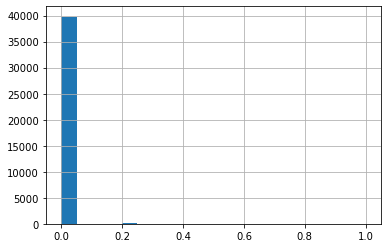

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


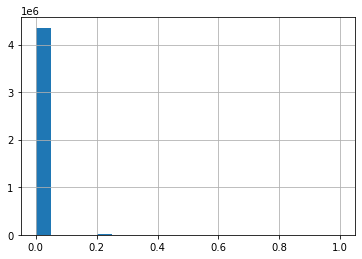




############## entity_comm_usg_comm_id_comm_usage_counts_active_mbr ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_mbr ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_mbr ##############
AxesSubplot(0.125,0.125;0.775x0.755)


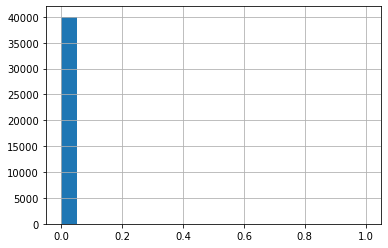

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


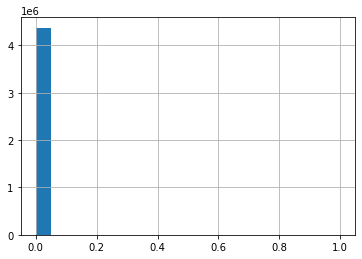




############## entity_comm_usg_comm_id_comm_usage_counts_active_amnw ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_amnw ##############
############## entity_comm_usg_comm_id_comm_usage_counts_active_amnw ##############
AxesSubplot(0.125,0.125;0.775x0.755)


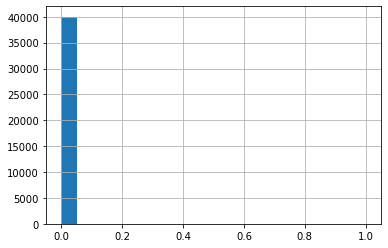

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


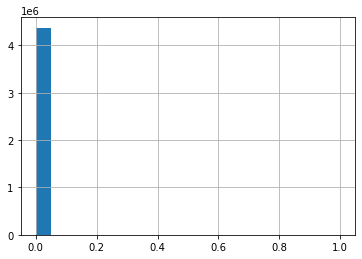




############## entity_comm_usg_comm_id_comm_usage_counts_history_po ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_po ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_po ##############
AxesSubplot(0.125,0.125;0.775x0.755)


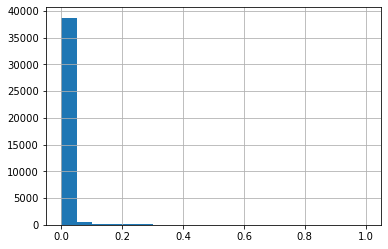

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


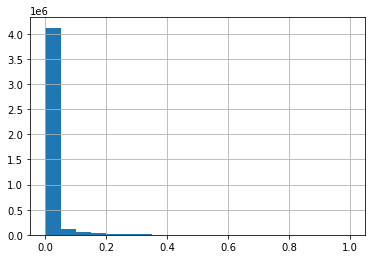




############## entity_comm_usg_comm_id_comm_usage_counts_history_web ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_web ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_web ##############
AxesSubplot(0.125,0.125;0.775x0.755)


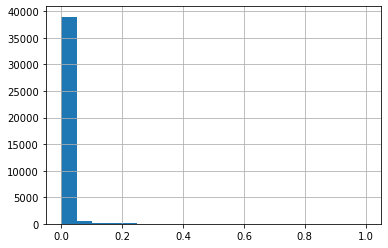

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


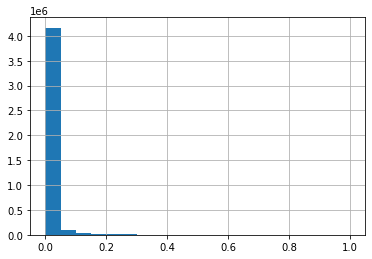




############## entity_comm_usg_comm_id_comm_usage_counts_history_op ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_op ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_op ##############
AxesSubplot(0.125,0.125;0.775x0.755)


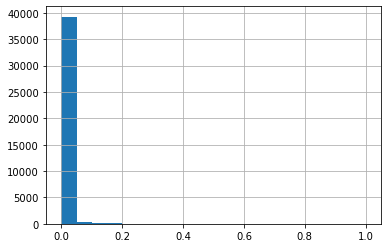

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


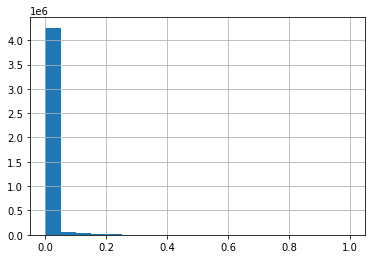




############## entity_comm_usg_comm_id_comm_usage_counts_history_pp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_pp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_pp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


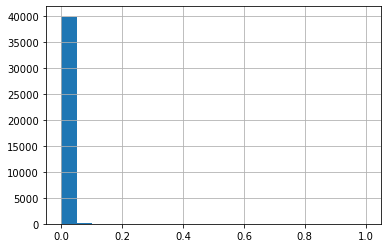

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


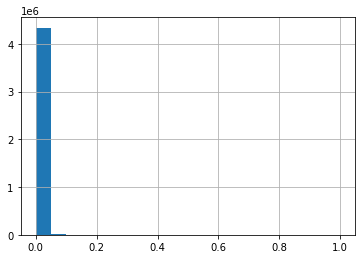




############## entity_comm_usg_comm_id_comm_usage_counts_history_arch ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_arch ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_arch ##############
AxesSubplot(0.125,0.125;0.775x0.755)


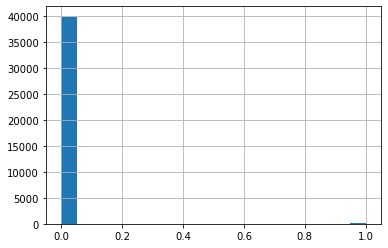

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


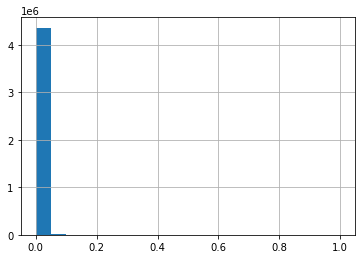




############## entity_comm_usg_comm_id_comm_usage_counts_history_jama ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_jama ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_jama ##############
AxesSubplot(0.125,0.125;0.775x0.755)


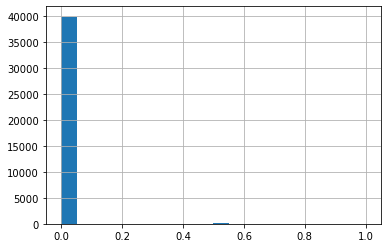

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


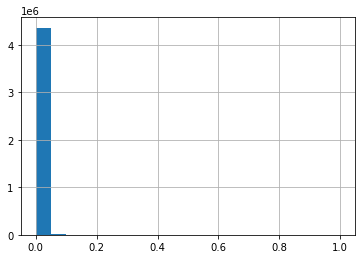




############## entity_comm_usg_comm_id_comm_usage_counts_history_amc ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_amc ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_amc ##############
AxesSubplot(0.125,0.125;0.775x0.755)


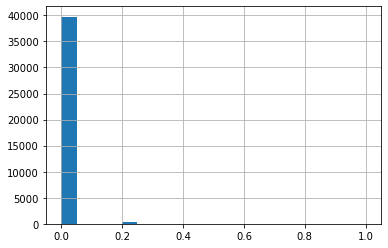

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


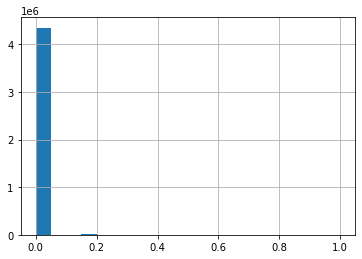




############## entity_comm_usg_comm_id_comm_usage_counts_history_mshp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_mshp ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_mshp ##############
AxesSubplot(0.125,0.125;0.775x0.755)


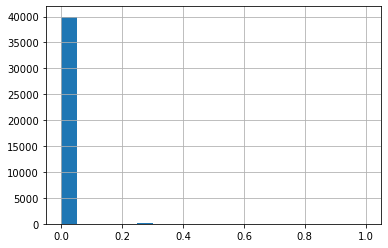

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


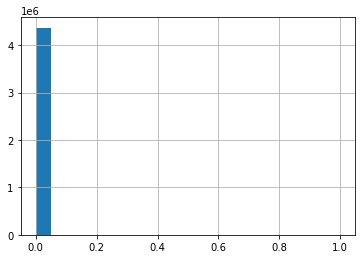




############## entity_comm_usg_comm_id_comm_usage_counts_history_bill ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_bill ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_bill ##############
AxesSubplot(0.125,0.125;0.775x0.755)


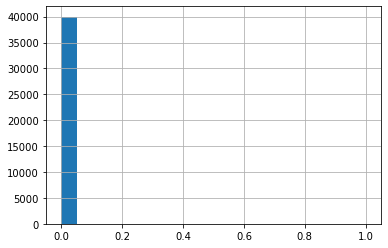

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


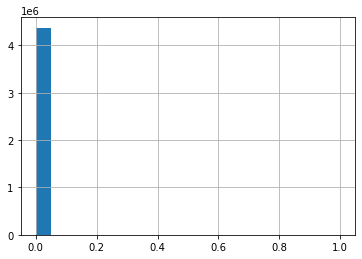




############## entity_comm_usg_comm_id_comm_usage_counts_history_amnw ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_amnw ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_amnw ##############
AxesSubplot(0.125,0.125;0.775x0.755)


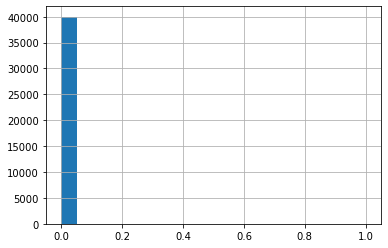

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


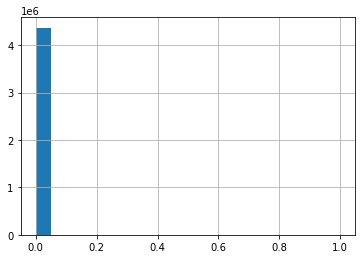




############## entity_comm_usg_comm_id_comm_usage_counts_history_mbr ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_mbr ##############
############## entity_comm_usg_comm_id_comm_usage_counts_history_mbr ##############
AxesSubplot(0.125,0.125;0.775x0.755)


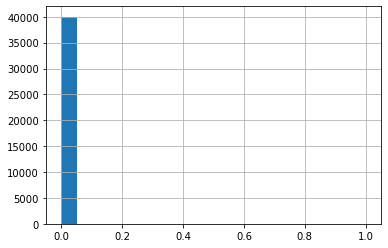

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


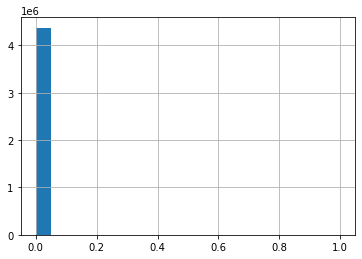




############## has_newer_active_license_elsewhere ##############
############## has_newer_active_license_elsewhere ##############
############## has_newer_active_license_elsewhere ##############
AxesSubplot(0.125,0.125;0.775x0.755)


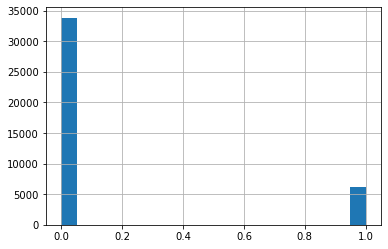

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


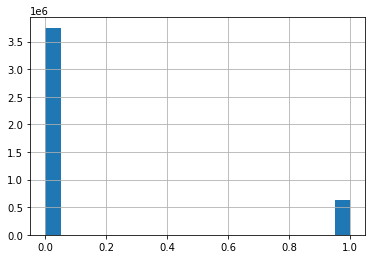




############## has_older_active_license_elsewhere ##############
############## has_older_active_license_elsewhere ##############
############## has_older_active_license_elsewhere ##############
AxesSubplot(0.125,0.125;0.775x0.755)


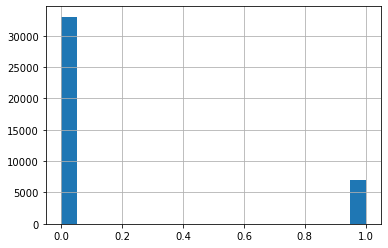

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


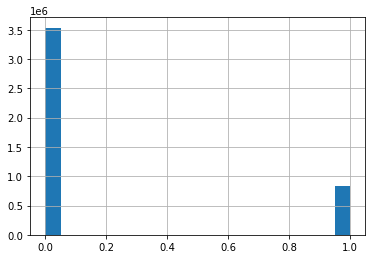




############## has_active_license_in_this_state ##############
############## has_active_license_in_this_state ##############
############## has_active_license_in_this_state ##############
AxesSubplot(0.125,0.125;0.775x0.755)


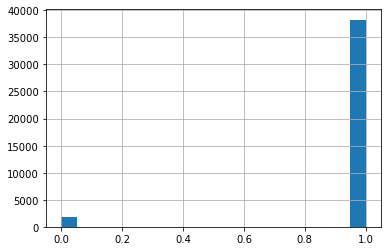

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


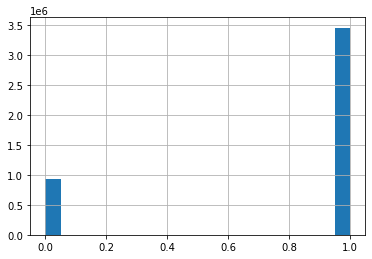




############## years_licensed_in_this_state ##############
############## years_licensed_in_this_state ##############
############## years_licensed_in_this_state ##############
AxesSubplot(0.125,0.125;0.775x0.755)


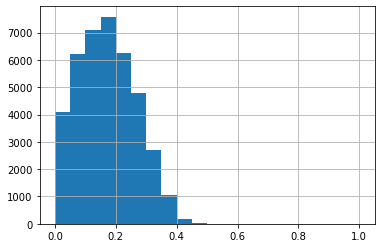

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


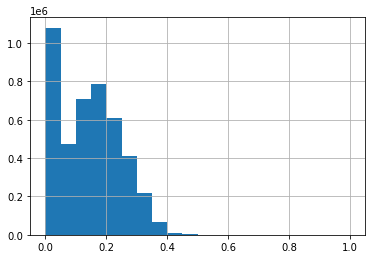




############## license_this_state_years_since_expiration ##############
############## license_this_state_years_since_expiration ##############
############## license_this_state_years_since_expiration ##############
AxesSubplot(0.125,0.125;0.775x0.755)


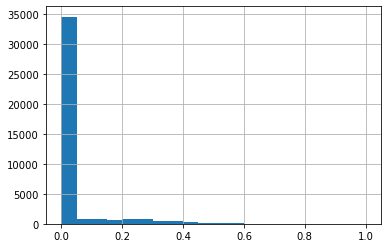

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


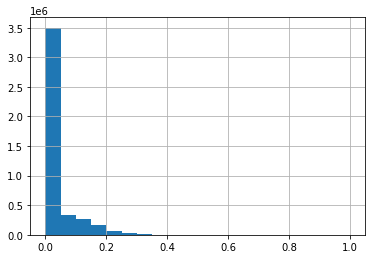




############## humach_years_since_survey ##############
############## humach_years_since_survey ##############
############## humach_years_since_survey ##############
AxesSubplot(0.125,0.125;0.775x0.755)


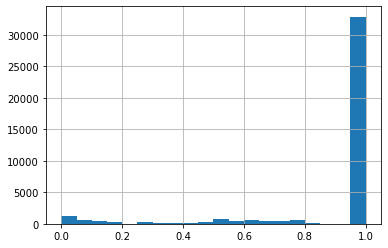

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


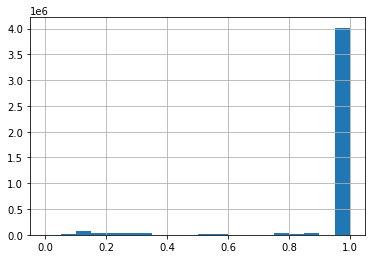




############## humach_never_surveyed ##############
############## humach_never_surveyed ##############
############## humach_never_surveyed ##############
AxesSubplot(0.125,0.125;0.775x0.755)


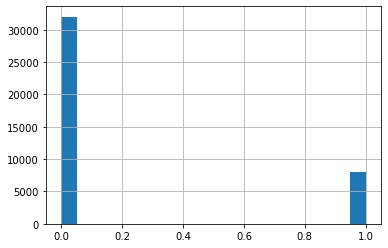

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


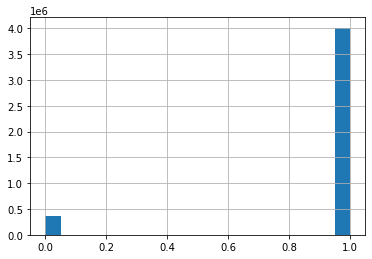




############## humach_address_result_unknown ##############
############## humach_address_result_unknown ##############
############## humach_address_result_unknown ##############
AxesSubplot(0.125,0.125;0.775x0.755)


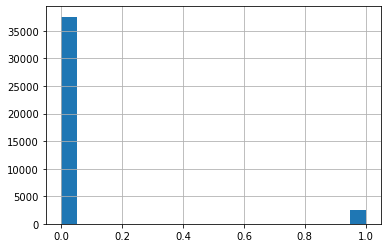

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


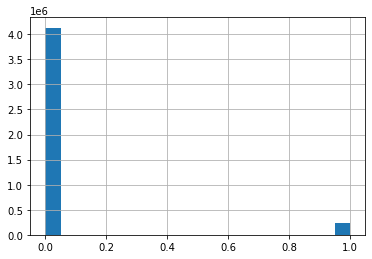




############## humach_address_result_correct ##############
############## humach_address_result_correct ##############
############## humach_address_result_correct ##############
AxesSubplot(0.125,0.125;0.775x0.755)


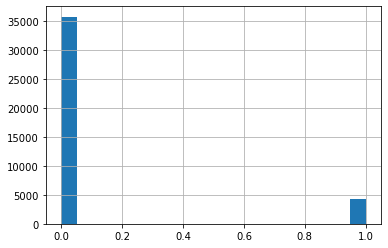

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


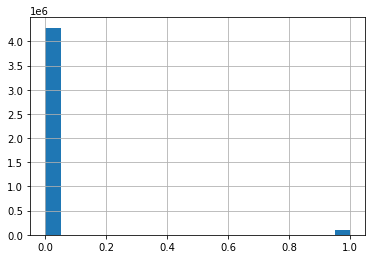




############## humach_address_result_incorrect ##############
############## humach_address_result_incorrect ##############
############## humach_address_result_incorrect ##############
AxesSubplot(0.125,0.125;0.775x0.755)


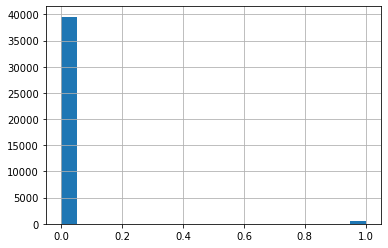

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


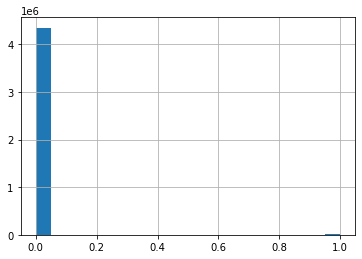




############## triangulation_iqvia_agreement ##############
############## triangulation_iqvia_agreement ##############
############## triangulation_iqvia_agreement ##############
AxesSubplot(0.125,0.125;0.775x0.755)


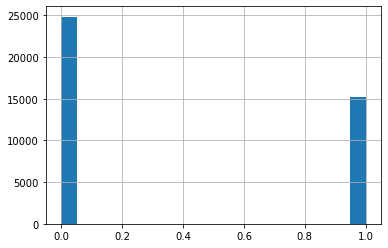

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


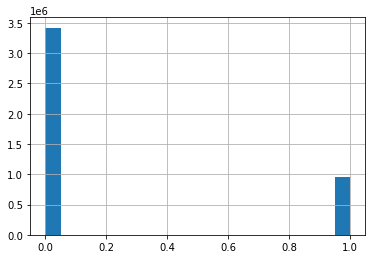




############## triangulation_iqvia_other ##############
############## triangulation_iqvia_other ##############
############## triangulation_iqvia_other ##############
AxesSubplot(0.125,0.125;0.775x0.755)


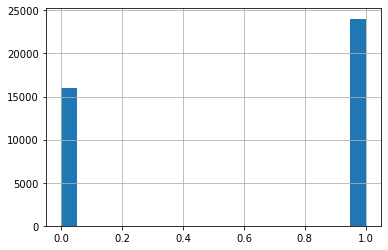

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


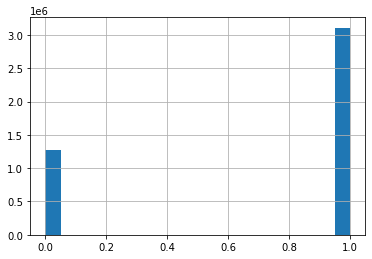




############## triangulation_symphony_agreement ##############
############## triangulation_symphony_agreement ##############
############## triangulation_symphony_agreement ##############
AxesSubplot(0.125,0.125;0.775x0.755)


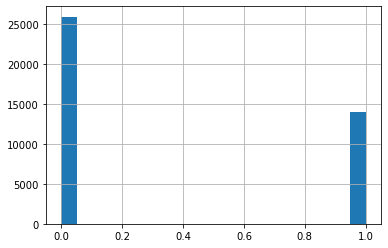

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


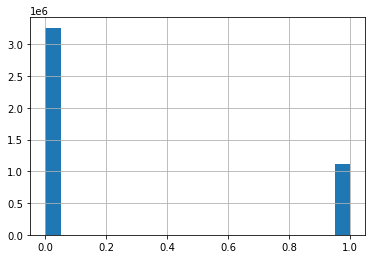




############## triangulation_symphony_other ##############
############## triangulation_symphony_other ##############
############## triangulation_symphony_other ##############
AxesSubplot(0.125,0.125;0.775x0.755)


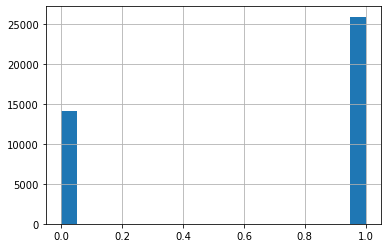

__________________________________
AxesSubplot(0.125,0.125;0.775x0.755)


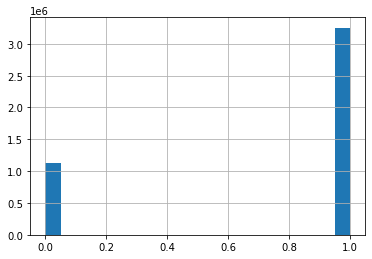

In [163]:
for col in used_features:
    print(f"############## {col} ##############")
    print(f"############## {col} ##############")
    print(f"############## {col} ##############")
    print(train[col].hist(bins=20))
    plt.show()
    print('__________________________________')
    print(pop_features[col].hist(bins=20))
    plt.show()
    print()
    print()
    print()

In [58]:
used_features

['entity_comm_address_age',
 'entity_comm_active_addresses',
 'entity_comm_address_active_frequency',
 'entity_comm_src_cat_code_roster',
 'entity_comm_src_cat_code_obsolete',
 'entity_comm_src_cat_code_phone-call',
 'entity_comm_src_cat_code_ppa',
 'entity_comm_src_cat_code_other',
 'entity_comm_src_cat_code_acs',
 'entity_comm_src_cat_code_oldcc',
 'entity_comm_src_cat_code_pubs',
 'entity_comm_src_cat_code_mbshp-mail',
 'entity_comm_src_cat_code_white-mail',
 'entity_comm_src_cat_code_req-cards',
 'entity_comm_src_cat_code_ama-org',
 'entity_comm_src_cat_code_list-house',
 'entity_comm_src_cat_code_group',
 'entity_comm_src_cat_code_returned',
 'entity_comm_src_cat_code_e-mail',
 'entity_comm_src_cat_code_web',
 'entity_comm_src_cat_code_mbshp-web',
 'entity_comm_src_cat_code_internet',
 'entity_comm_src_cat_code_mrkt-rsrch',
 'entity_comm_src_cat_code_usc-outbnd',
 'entity_comm_src_cat_code_schl-hosp',
 'entity_comm_src_cat_code_gme',
 'entity_comm_src_cat_code_amc',
 'entity_comm_

In [107]:
pop_features = pop_features[used_features]

In [59]:
pop_features_final = pd.DataFrame()
for col in train.columns:
    pop_features_final[col] = pop_features[col]

In [60]:

# ensemble_predictions = predict_ensemble(predictors, pop_features_final)



In [62]:
assert all(pop_features_final.columns == train.columns)

In [63]:
#ensemble_predictions[:10]

In [64]:
#ensemble_predictions[:10]#

In [65]:
tdf.shape

(40025, 92)

In [66]:
#pop['me'].drop_duplicates().shape[0], pop['comm_id'].drop_duplicates().shape[0], pop['address_key'].drop_duplicates().shape[0]

In [113]:
pop[['me', 'address_key']].drop_duplicates().shape

(3122317, 2)

In [67]:
pop

,me,entity_id,comm_id,address_key,state_cd,key,entity_comm_address_age,entity_comm_active_addresses,entity_comm_address_active_frequency,entity_comm_src_cat_code_roster,entity_comm_src_cat_code_obsolete,entity_comm_src_cat_code_phone-call,entity_comm_src_cat_code_ppa,entity_comm_src_cat_code_other,entity_comm_src_cat_code_acs,entity_comm_src_cat_code_oldcc,entity_comm_src_cat_code_pubs,entity_comm_src_cat_code_mbshp-mail,entity_comm_src_cat_code_white-mail,entity_comm_src_cat_code_req-cards,entity_comm_src_cat_code_ama-org,entity_comm_src_cat_code_list-house,entity_comm_src_cat_code_group,entity_comm_src_cat_code_returned,entity_comm_src_cat_code_e-mail,entity_comm_src_cat_code_web,entity_comm_src_cat_code_mbshp-web,entity_comm_src_cat_code_internet,entity_comm_src_cat_code_mrkt-rsrch,entity_comm_src_cat_code_lock_box,entity_comm_src_cat_code_usc-outbnd,entity_comm_src_cat_code_schl-hosp,entity_comm_src_cat_code_gme,entity_comm_src_cat_code_amc,entity_comm_src_cat_code_mbshp-othr,entity_comm_src_cat_code_mfload,entity_comm_src_cat_code_addr-ver,entity_comm_src_cat_code_res-tipon,entity_comm_src_cat_code_ncoa,entity_comm_src_cat_code_dea,entity_comm_src_cat_code_acxiomncoa,entity_comm_src_cat_code_ecf-cnvrsn,entity_comm_src_cat_code_acxiomlode,entity_comm_src_cat_code_admit-hos,entity_comm_src_cat_code_affil-grp,entity_comm_src_cat_code_cgmt,entity_comm_src_cat_code_prfsol,entity_comm_src_cat_code_acxiom,entity_comm_src_cat_code_polo,entity_comm_src_cat_code_advr,entity_comm_src_cat_code_eci,entity_comm_src_cat_code_medec,entity_comm_src_cat_code_phnsurv,entity_comm_src_cat_code_acxiomplus,entity_comm_src_cat_code_pps,entity_comm_src_cat_code_ppma,entity_comm_src_cat_code_stu-matric,entity_comm_src_cat_code_websurv,entity_comm_src_cat_code_cgmt-exc,entity_comm_src_cat_code_npi,entity_comm_src_cat_code_federation,entity_comm_src_cat_code_outreach,entity_comm_src_cat_code_cme-reg,entity_comm_src_cat_code_mbshp-phon,entity_comm_src_cat_code_mbshp-purl,entity_comm_src_cat_code_fast-track,entity_comm_src_cat_code_interact,entity_comm_src_cat_code_yellow,entity_comm_src_cat_code_per,entity_comm_src_cat_code_coa-ps,entity_comm_usg_comm_id_comm_usage_counts_active_op,entity_comm_usg_comm_id_comm_usage_counts_active_po,entity_comm_usg_comm_id_comm_usage_counts_active_web,entity_comm_usg_comm_id_comm_usage_counts_active_pp,entity_comm_usg_comm_id_comm_usage_counts_active_arch,entity_comm_usg_comm_id_comm_usage_counts_active_jama,entity_comm_usg_comm_id_comm_usage_counts_active_mshp,entity_comm_usg_comm_id_comm_usage_counts_active_bill,entity_comm_usg_comm_id_comm_usage_counts_active_amc,entity_comm_usg_comm_id_comm_usage_counts_active_mbr,entity_comm_usg_comm_id_comm_usage_counts_active_amnw,entity_comm_usg_comm_id_comm_usage_counts_active_pe,entity_comm_usg_comm_id_comm_usage_counts_active_pf,entity_comm_usg_comm_id_comm_usage_counts_active_pv,entity_comm_usg_comm_id_comm_usage_counts_history_po,entity_comm_usg_comm_id_comm_usage_counts_history_web,entity_comm_usg_comm_id_comm_usage_counts_history_op,entity_comm_usg_comm_id_comm_usage_counts_history_pp,entity_comm_usg_comm_id_comm_usage_counts_history_arch,entity_comm_usg_comm_id_comm_usage_counts_history_jama,entity_comm_usg_comm_id_comm_usage_counts_history_amc,entity_comm_usg_comm_id_comm_usage_counts_history_mshp,entity_comm_usg_comm_id_comm_usage_counts_history_bill,entity_comm_usg_comm_id_comm_usage_counts_history_amnw,entity_comm_usg_comm_id_comm_usage_counts_history_mbr,entity_comm_usg_comm_id_comm_usage_counts_history_pe,entity_comm_usg_comm_id_comm_usage_counts_history_pf,entity_comm_usg_comm_id_comm_usage_counts_history_mr,entity_comm_usg_comm_id_comm_usage_counts_history_pv,has_newer_active_license_elsewhere,has_older_active_license_elsewhere,has_active_license_in_this_state,years_licensed_in_this_state,license_this_state_years_since_expiration,humach_years_since_survey,humach_never_surveyed,humach_address_result_unknown,humach_address_result_correct,humach_address_result_in

In [162]:
pop.drop(columns=['comm_id', 'entity_comm_address_age']).drop_duplicates().shape

(4106782, 111)

In [163]:
pop.shape[0]

4375220

In [158]:
assert (pop_features_final.columns == X_test.columns).all()

<AxesSubplot:>

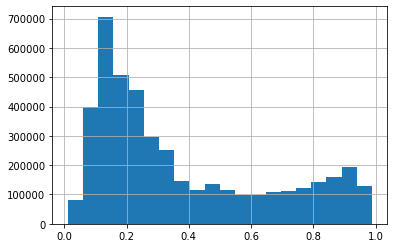

In [159]:
y_pred = pd.Series([p[1] for p in model.predict_proba(pop_features_final)])
y_pred.hist(bins=20)

In [160]:
X_test.shape

(8005, 84)

In [161]:
pop_features_final.shape

(4375220, 84)

<AxesSubplot:>

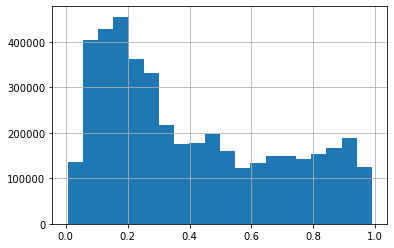

In [162]:
y_pred = pd.Series([p[1] for p in xgb.predict_proba(pop_features_final)])
y_pred.hist(bins=20)

In [164]:
# pd.Series(ensemble_predictions).hist(bins=20)

In [165]:
#y_pred = pd.Series([p[1] for p in rf.predict_proba(pop_features_final)])
#y_pred.hist(bins=20)

# XGB old pop dist?

<AxesSubplot:>

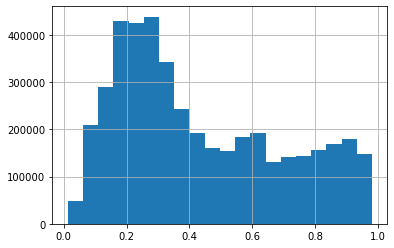

In [69]:
y_pred = pd.Series([p[1] for p in xgb.predict_proba(pop_features_final)])
y_pred.hist(bins=20)

# USE XGBOOST

In [70]:
pdf = pop[[c for c in info_cols if c in pop.columns]]
pdf['prediction'] = y_pred

C:\Users\Garrett\AppData\Local\Temp/ipykernel_39032/936728646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['prediction'] = y_pred


In [71]:
pcd = pd.read_csv('../data/2022-08-16/post_cd_2_comm_id.txt', sep='|', dtype=str)
pcd

,POST_CD_ID,SRC_POST_KEY
0,11944841,909339.0
1,11944842,904019.0
2,11944843,904067.0
3,11944844,909540.0
4,11944845,909700.0
...,...,...
20659919,11944836,908250.0
20659920,11944837,908628.0
20659921,11944838,908667.0
20659922,11944839,908812.0


In [72]:
pcd['SRC_POST_KEY'] = pcd['SRC_POST_KEY'].astype(str).apply(lambda x: x[:-2] if x.endswith('.0') else x)

In [73]:
pid = pd.read_csv('../data/2022-08-16/party_id_2_me.txt', sep='|', dtype=str)
pid

,PARTY_ID,ME
0,1888590,00102500164
1,1889235,00102990919
2,1904405,00102840976
3,1894036,00401530789
4,1892959,00106930210
...,...,...
1780538,16992039,05104260596
1780539,16992049,02405260347
1780540,16992050,02401242662
1780541,16992111,05606260344


In [74]:
pdf

,me,entity_id,comm_id,address_key,state_cd,prediction
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.403802
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.752684
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.552828
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.587477
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.445919
...,...,...,...,...,...,...
4375215,96501960036,27921214,8355689,730 W MARKET ST_45801,OH,0.397596
4375216,96501960036,27921214,3813070,800 SPRUCE ST_19107,PA,0.286221
4375217,96501960044,28518902,7057733,142 S MAIN ST_24541,VA,0.621475
4375218,96501960052,39355091,3537863,1 MEDICAL CENTER BLVD_27157,NC,0.890077


In [75]:
pdf = pdf.merge(pid, left_on='me', right_on='ME', how='left')
del pdf['ME']
pdf.head()

,me,entity_id,comm_id,address_key,state_cd,prediction,PARTY_ID
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.403802,1849563
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.752684,1849563
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.552828,1849563
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.587477,1849563
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.445919,1849563


In [172]:
pdf = pdf.merge(pcd, left_on='comm_id', right_on='SRC_POST_KEY', how='left')
del pdf['SRC_POST_KEY']
pdf.head()

,me,entity_id,comm_id,address_key,state_cd,prediction,PARTY_ID,POST_CD_ID
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.267367,1849563,12316493
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.729186,1849563,12129524
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.575675,1849563,12394318
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.635782,1849563,16396215
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.311854,1849563,12513844


In [78]:
addr = pd.read_csv(
    r'C:\Users\Garrett\Documents\AMA\address_scoring\post_addr_at_clean.txt', 
    sep='|', 
    dtype=str
)
addr.head()

,comm_id,addr_line0,addr_line1,addr_line2,city_cd,state_cd,zip
0,718619,NaN,NaN,NaN,BALBOA HEIGHT,NaN,NaN
1,718946,NaN,NaN,ADDRESS UNKNOWN,NaN,NaN,NaN
2,719453,NaN,NaN,ADDRESS UNKNOWN,NaN,NaN,NaN
3,719594,NaN,NaN,ADDRESS UNKNOWN,NaN,NaN,NaN
4,719600,NaN,BAS SCI BLDG 700 WILLIAM A,WINNIPEG MAN CANADA,NaN,NaN,NaN


In [79]:
addr.fillna('', inplace=True)

In [80]:
pdfm = pdf.merge(addr, on='comm_id')


In [82]:
pdfm['score'] = pdfm['prediction'].copy()

In [83]:
pdfm.head()

,me,entity_id,comm_id,address_key,state_cd_x,prediction,PARTY_ID,addr_line0,addr_line1,addr_line2,city_cd,state_cd_y,zip,score
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.403802,1849563,,,1025 7th Ave N,St Petersburg,FL,33705,0.403802
1,02501610235,5459723,4744607,1025 7TH AVE N_33705,FL,0.257594,2074368,,,1025 7th Ave N,St Petersburg,FL,33705,0.257594
2,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.752684,1849563,,,700 6th St S,St Petersburg,FL,33701,0.752684
3,01103980352,2713902,727664,700 6TH ST S_33701,FL,0.773261,1931355,,,700 6th St S,St Petersburg,FL,33701,0.773261
4,01104000301,2716814,727664,700 6TH ST S_33701,FL,0.754417,1880455,,,700 6th St S,St Petersburg,FL,33701,0.754417


In [87]:
del pdfm['state_cd_y']
pdfm['state_cd'] = pdfm['state_cd_x'].copy()
del pdfm['state_cd_x']

In [88]:
pdfm.to_csv(f'ADDRESS_SCORING_{today.date()}.csv', index=False)

In [173]:
pdf['score'] = pdf['prediction'].apply(lambda x: int(round(x*10)))
pdf.head()

,me,entity_id,comm_id,address_key,state_cd,prediction,PARTY_ID,POST_CD_ID,score
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.267367,1849563,12316493,3
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.729186,1849563,12129524,7
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.575675,1849563,12394318,6
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.635782,1849563,16396215,6
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.311854,1849563,12513844,3


In [174]:
pdf['score'] = pdf['prediction'].apply(lambda x: int(round(x*10)))
pdf.head()

,me,entity_id,comm_id,address_key,state_cd,prediction,PARTY_ID,POST_CD_ID,score
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.267367,1849563,12316493,3
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.729186,1849563,12129524,7
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.575675,1849563,12394318,6
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.635782,1849563,16396215,6
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.311854,1849563,12513844,3


In [175]:
pdf['score'] = pdf['score'].apply(lambda x: 1 if x == 0 else x)  # floor is 1


In [176]:
pdf['POST_CD_ID'].isna().any()

False

In [177]:
batchload = pd.DataFrame()


as_of_date = '2022-08-16'

batchload['PARTY_ID'] = pdf['PARTY_ID'].astype(str).apply(str.strip)
batchload['POST_CD_ID'] = pdf['POST_CD_ID'].astype(str).apply(str.strip)
batchload['AS_OF_DT'] = as_of_date
batchload['ADDR_SCORE'] = pdf['score']

batchload

,PARTY_ID,POST_CD_ID,AS_OF_DT,ADDR_SCORE
0,1849563,12316493,2022-08-16,3
1,1849563,12129524,2022-08-16,7
2,1849563,12394318,2022-08-16,6
3,1849563,16396215,2022-08-16,6
4,1849563,12513844,2022-08-16,3
...,...,...,...,...
4375215,3526200,12841937,2022-08-16,4
4375216,3526200,11460865,2022-08-16,3
4375217,3572171,14422477,2022-08-16,6
4375218,4764268,14554549,2022-08-16,9


In [178]:
batchload.to_csv(f'HSG_OfficeAddressScores_{as_of_date}.csv', index=False)

<AxesSubplot:>

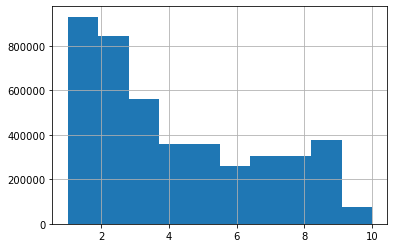

In [179]:
batchload['ADDR_SCORE'].hist(bins=10)

<AxesSubplot:>

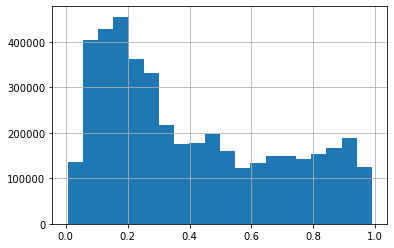

In [180]:
pdf['prediction'].hist(bins=20)

In [134]:
X_test.columns.values

array(['entity_comm_address_age', 'entity_comm_active_addresses',
       'entity_comm_address_active_frequency',
       'entity_comm_src_cat_code_phone-call',
       'entity_comm_src_cat_code_amc', 'entity_comm_src_cat_code_ppa',
       'entity_comm_src_cat_code_mfload',
       'entity_comm_src_cat_code_mbshp-mail',
       'entity_comm_src_cat_code_acs', 'entity_comm_src_cat_code_pubs',
       'entity_comm_src_cat_code_roster',
       'entity_comm_src_cat_code_ama-org',
       'entity_comm_src_cat_code_white-mail',
       'entity_comm_src_cat_code_list-house',
       'entity_comm_src_cat_code_dea',
       'entity_comm_src_cat_code_affil-grp',
       'entity_comm_src_cat_code_acxiomlode',
       'entity_comm_src_cat_code_acxiomncoa',
       'entity_comm_src_cat_code_prfsol', 'entity_comm_src_cat_code_ncoa',
       'entity_comm_src_cat_code_other',
       'entity_comm_src_cat_code_admit-hos',
       'entity_comm_src_cat_code_group', 'entity_comm_src_cat_code_pps',
       'entity_comm_src

In [136]:
pdf

,me,entity_id,comm_id,address_key,state_cd,prediction,PARTY_ID,POST_CD_ID,score
0,00102000013,1234580,4744607,1025 7TH AVE N_33705,FL,0.847672,1849563,12316493,8
1,00102000013,1234580,727664,700 6TH ST S_33701,FL,0.726463,1849563,12129524,7
2,00102000013,1234580,6625144,1501 PASADENA AVE S_33707,FL,0.758534,1849563,12394318,8
3,00102000013,1234580,6616913,810 SAINT VINCENTS DR_35205,AL,0.687864,1849563,16396215,7
4,00102000013,1234580,9127102,8711 BRYAN DAIRY RD_33777,FL,0.847672,1849563,12513844,8
...,...,...,...,...,...,...,...,...,...
4375215,96501960036,27921214,8355689,730 W MARKET ST_45801,OH,0.739164,3526200,12841937,7
4375216,96501960036,27921214,3813070,800 SPRUCE ST_19107,PA,0.524194,3526200,11460865,5
4375217,96501960044,28518902,7057733,142 S MAIN ST_24541,VA,0.802764,3572171,14422477,8
4375218,96501960052,39355091,3537863,1 MEDICAL CENTER BLVD_27157,NC,0.866581,4764268,14554549,9


In [135]:
used_features

['entity_comm_address_age',
 'entity_comm_active_addresses',
 'entity_comm_address_active_frequency',
 'entity_comm_src_cat_code_roster',
 'entity_comm_src_cat_code_obsolete',
 'entity_comm_src_cat_code_phone-call',
 'entity_comm_src_cat_code_ppa',
 'entity_comm_src_cat_code_other',
 'entity_comm_src_cat_code_acs',
 'entity_comm_src_cat_code_oldcc',
 'entity_comm_src_cat_code_pubs',
 'entity_comm_src_cat_code_mbshp-mail',
 'entity_comm_src_cat_code_white-mail',
 'entity_comm_src_cat_code_req-cards',
 'entity_comm_src_cat_code_ama-org',
 'entity_comm_src_cat_code_list-house',
 'entity_comm_src_cat_code_group',
 'entity_comm_src_cat_code_returned',
 'entity_comm_src_cat_code_e-mail',
 'entity_comm_src_cat_code_web',
 'entity_comm_src_cat_code_mbshp-web',
 'entity_comm_src_cat_code_internet',
 'entity_comm_src_cat_code_mrkt-rsrch',
 'entity_comm_src_cat_code_usc-outbnd',
 'entity_comm_src_cat_code_schl-hosp',
 'entity_comm_src_cat_code_gme',
 'entity_comm_src_cat_code_amc',
 'entity_comm_

In [133]:
used_features == X_test.columns.values

array([ True,  True,  True, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [477]:
pop_features.head()

entity_comm_address_age  \
me        entity_id comm_id address_key                 state_cd                            
102000013 1234580   4744607 1025 7th Ave N_33705        FL                      15.898630   
                    727664  700 6th St S_33701          FL                      21.263014   
                    6625144 1501 Pasadena Ave S_33707   FL                      15.684932   
                    6616913 810 Saint Vincents Dr_35205 AL                      12.405479   
                    9127102 8711 Bryan Dairy Rd_33777   FL                      18.427397   

                                                                  entity_comm_active_addresses  \
me        entity_id comm_id address_key                 state_cd                                 
102000013 1234580   4744607 1025 7th Ave N_33705        FL                                 1.0   
                    727664  700 6th St S_33701          FL                                 1.0   
                    6625144 1501 Pasadena Ave S_33707   FL                                 1.0   
                    6616913 810 Saint Vincents Dr_35205 AL                                 1.0   
                    9127102 8711 Bryan Dairy Rd_33777   FL                                 1.0   

                                                                  entity_comm_address_active_frequency  \
me        entity_id comm_id address_key                 state_cd                                         
102000013 1234580   4744607 1025 7th Ave N_33705        FL                                         0.0   
                    727664  700 6th St S_33701          FL                                         1.0   
                    6625144 1501 Pasadena Ave S_33707   FL                                        12.0   
                    6616913 810 Saint Vincents Dr_35205 AL                                        42.0   
                    9127102 8711 Bryan Dairy Rd_33777   FL                                         0.0   

                                                                  entity_comm_src_cat_code_roster  \
me        entity_id comm_id address_key                 state_cd                                    
102000013 1234580   4744607 1025 7th Ave N_33705        FL                                    0.0   
                    727664  700 6th St S_33701          FL                                    0.0   
                    6625144 1501 Pasadena Ave S_33707   FL                                    0.0   
                    6616913 810 Saint Vincents Dr_35205 AL                                    0.0   
                    9127102 8711 Bryan Dairy Rd_33777   FL                                    0.0   

                                                                  entity_comm_src_cat_code_obsolete  \
me        entity_id comm_id address_key                 state_cd                                      
102000013 1234580   4744607 1025 7th Ave N_33705        FL                                      0.0   
                    727664  700 6th St S_33701          FL                                      0.0   
                    6625144 1501 Pasadena Ave S_33707   FL                                      0.0   
                    6616913 810 Saint Vincents Dr_35205 AL                                      0.0   
                    9127102 8711 Bryan Dairy Rd_33777   FL                                      0.0   

                                                                  entity_comm_src_cat_code_phone-call  \
me        entity_id comm_id address_key                 state_cd                                        
102000013 1234580   4744607 1025 7th Ave N_33705        FL                                        0.0   
                    727664  700 6th St S_33701          FL                                        0.0   
                    6625144 1501 Pasadena Ave S_33707   FL                                        0.0   
                    6616913 8